# **\[CGSP\]** Chap 12.2 ~ 3: Power Spectral Density and its Estimators

신록예찬  
2022-12-27

In [4]:
using LinearAlgebra, Plots, FFTW, Statistics

# Preliminary Study

# Vectorization (mathematics)

<figure>
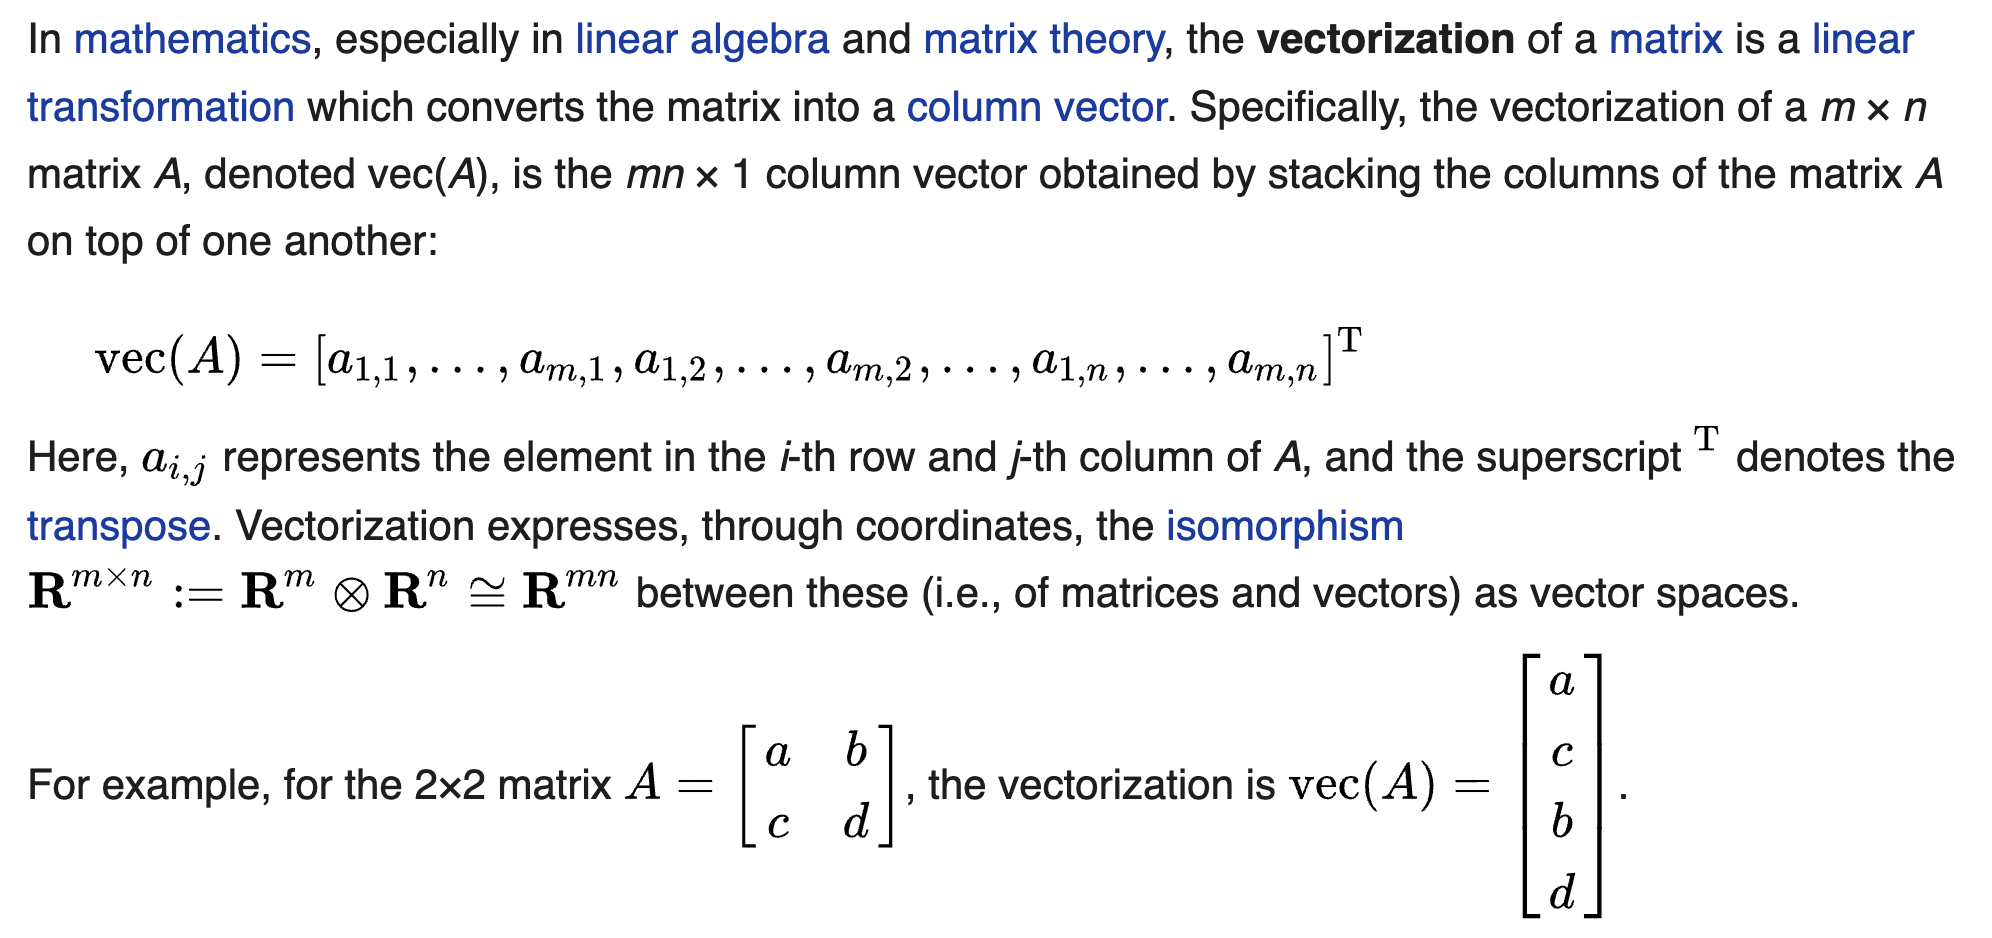
<figcaption aria-hidden="true">위키에서 긁은 그림</figcaption>
</figure>

(예제)

In [80]:
A= [1 2 
    3 4]

In [81]:
vec(A)

## Kronecker product

크로네커곱의 정의는 아래와 같다.

$${\bf A} \otimes {\bf B}
=\begin{bmatrix}
a_{11}{\bf B} & a_{12}{\bf B} & \dots & a_{1m}{\bf B} \\ 
a_{21}{\bf B} & a_{22}{\bf B} & \dots & a_{2m}{\bf B} \\ 
\dots & \dots & \dots & \dots \\
a_{n1}{\bf B} & a_{n2}{\bf B} & \dots & a_{nm}{\bf B} \\ 
\end{bmatrix}$$

두 행렬 ${\bf A}_{m\times n}$, ${\bf B}_{p\times q}$의 크로네커곱
${\bf A}\otimes {\bf B}$의 차원은 $mp \times nq$ 가 된다. 계산예시는
아래와 같다.

<figure>
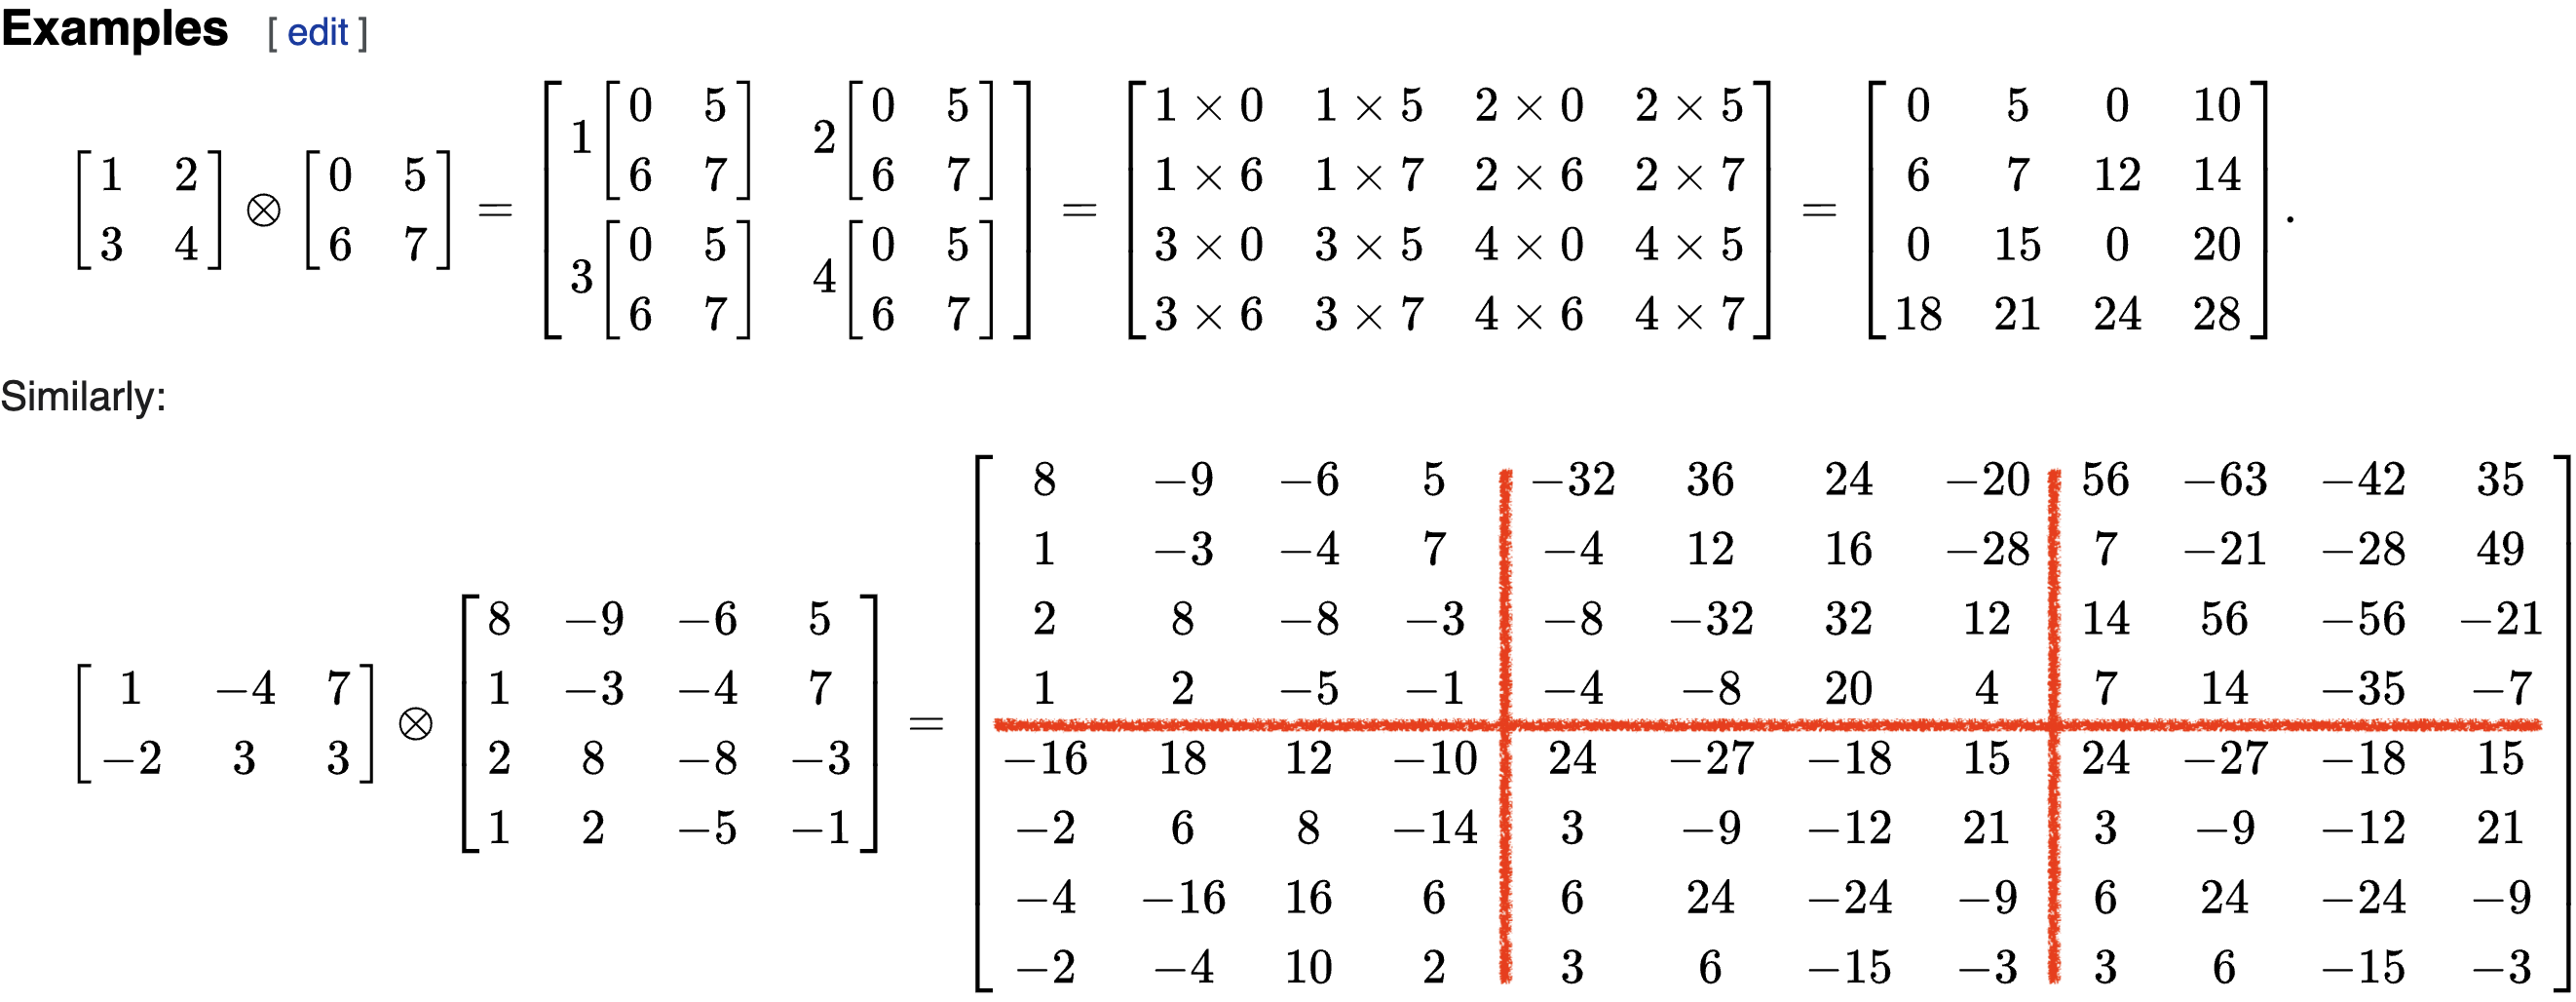
<figcaption aria-hidden="true">위키에서 긁은 예제, 글씨가 좀
작음</figcaption>
</figure>

크로네커곱에 대한 성질들이 위키에 많이 있으니 참고하면 좋다.

(예제1)

In [82]:
A= [1 2
    3 4]
B= [0 5
    6 7]
C = kron(A, B)

(예제2)

In [83]:
A= [1 -4 7; -2 3 3]
B= [8 -9 -6 -5; 1 -3 -4 7; 2 8 -8 -3; 1 2 -5 -1]
C = kron(A, B)

## Khatri–Rao product

카트리-라오곱은 매트릭스 ${\bf A}$와 ${\bf B}$가 같은 차원의
블락매트릭스로 정의될때 각 서브매트릭스의 크로네커 곱으로 정의된다.
정의와 계산예시는 아래와 같다.

<figure>
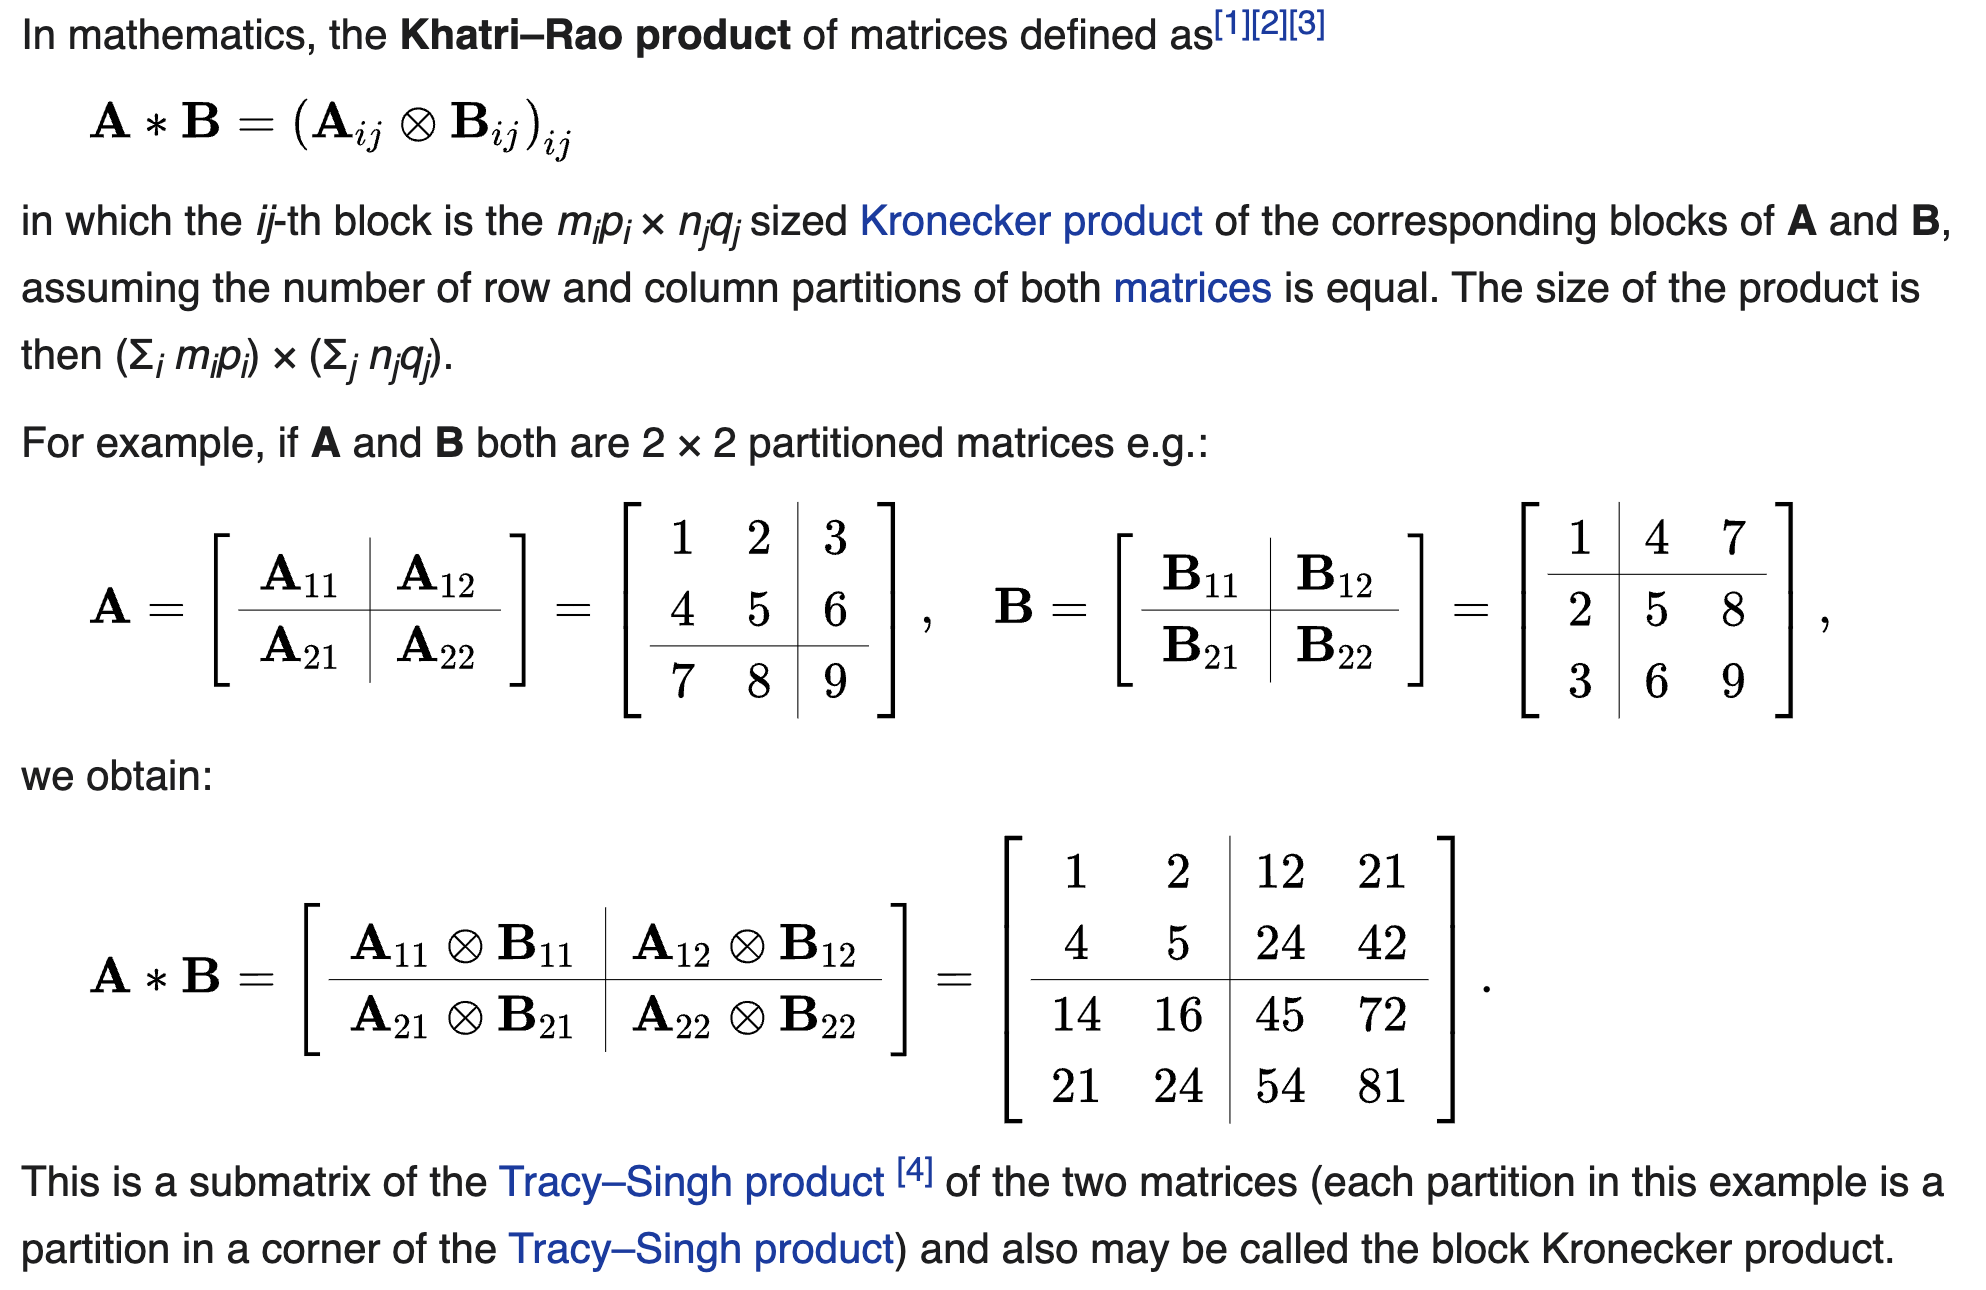
<figcaption aria-hidden="true">예시1: 위키에서 긁은 그림</figcaption>
</figure>

또 다른 계산예시는 아래와 같다. 이 예제는 중요하니까 구현해보자.

<figure>
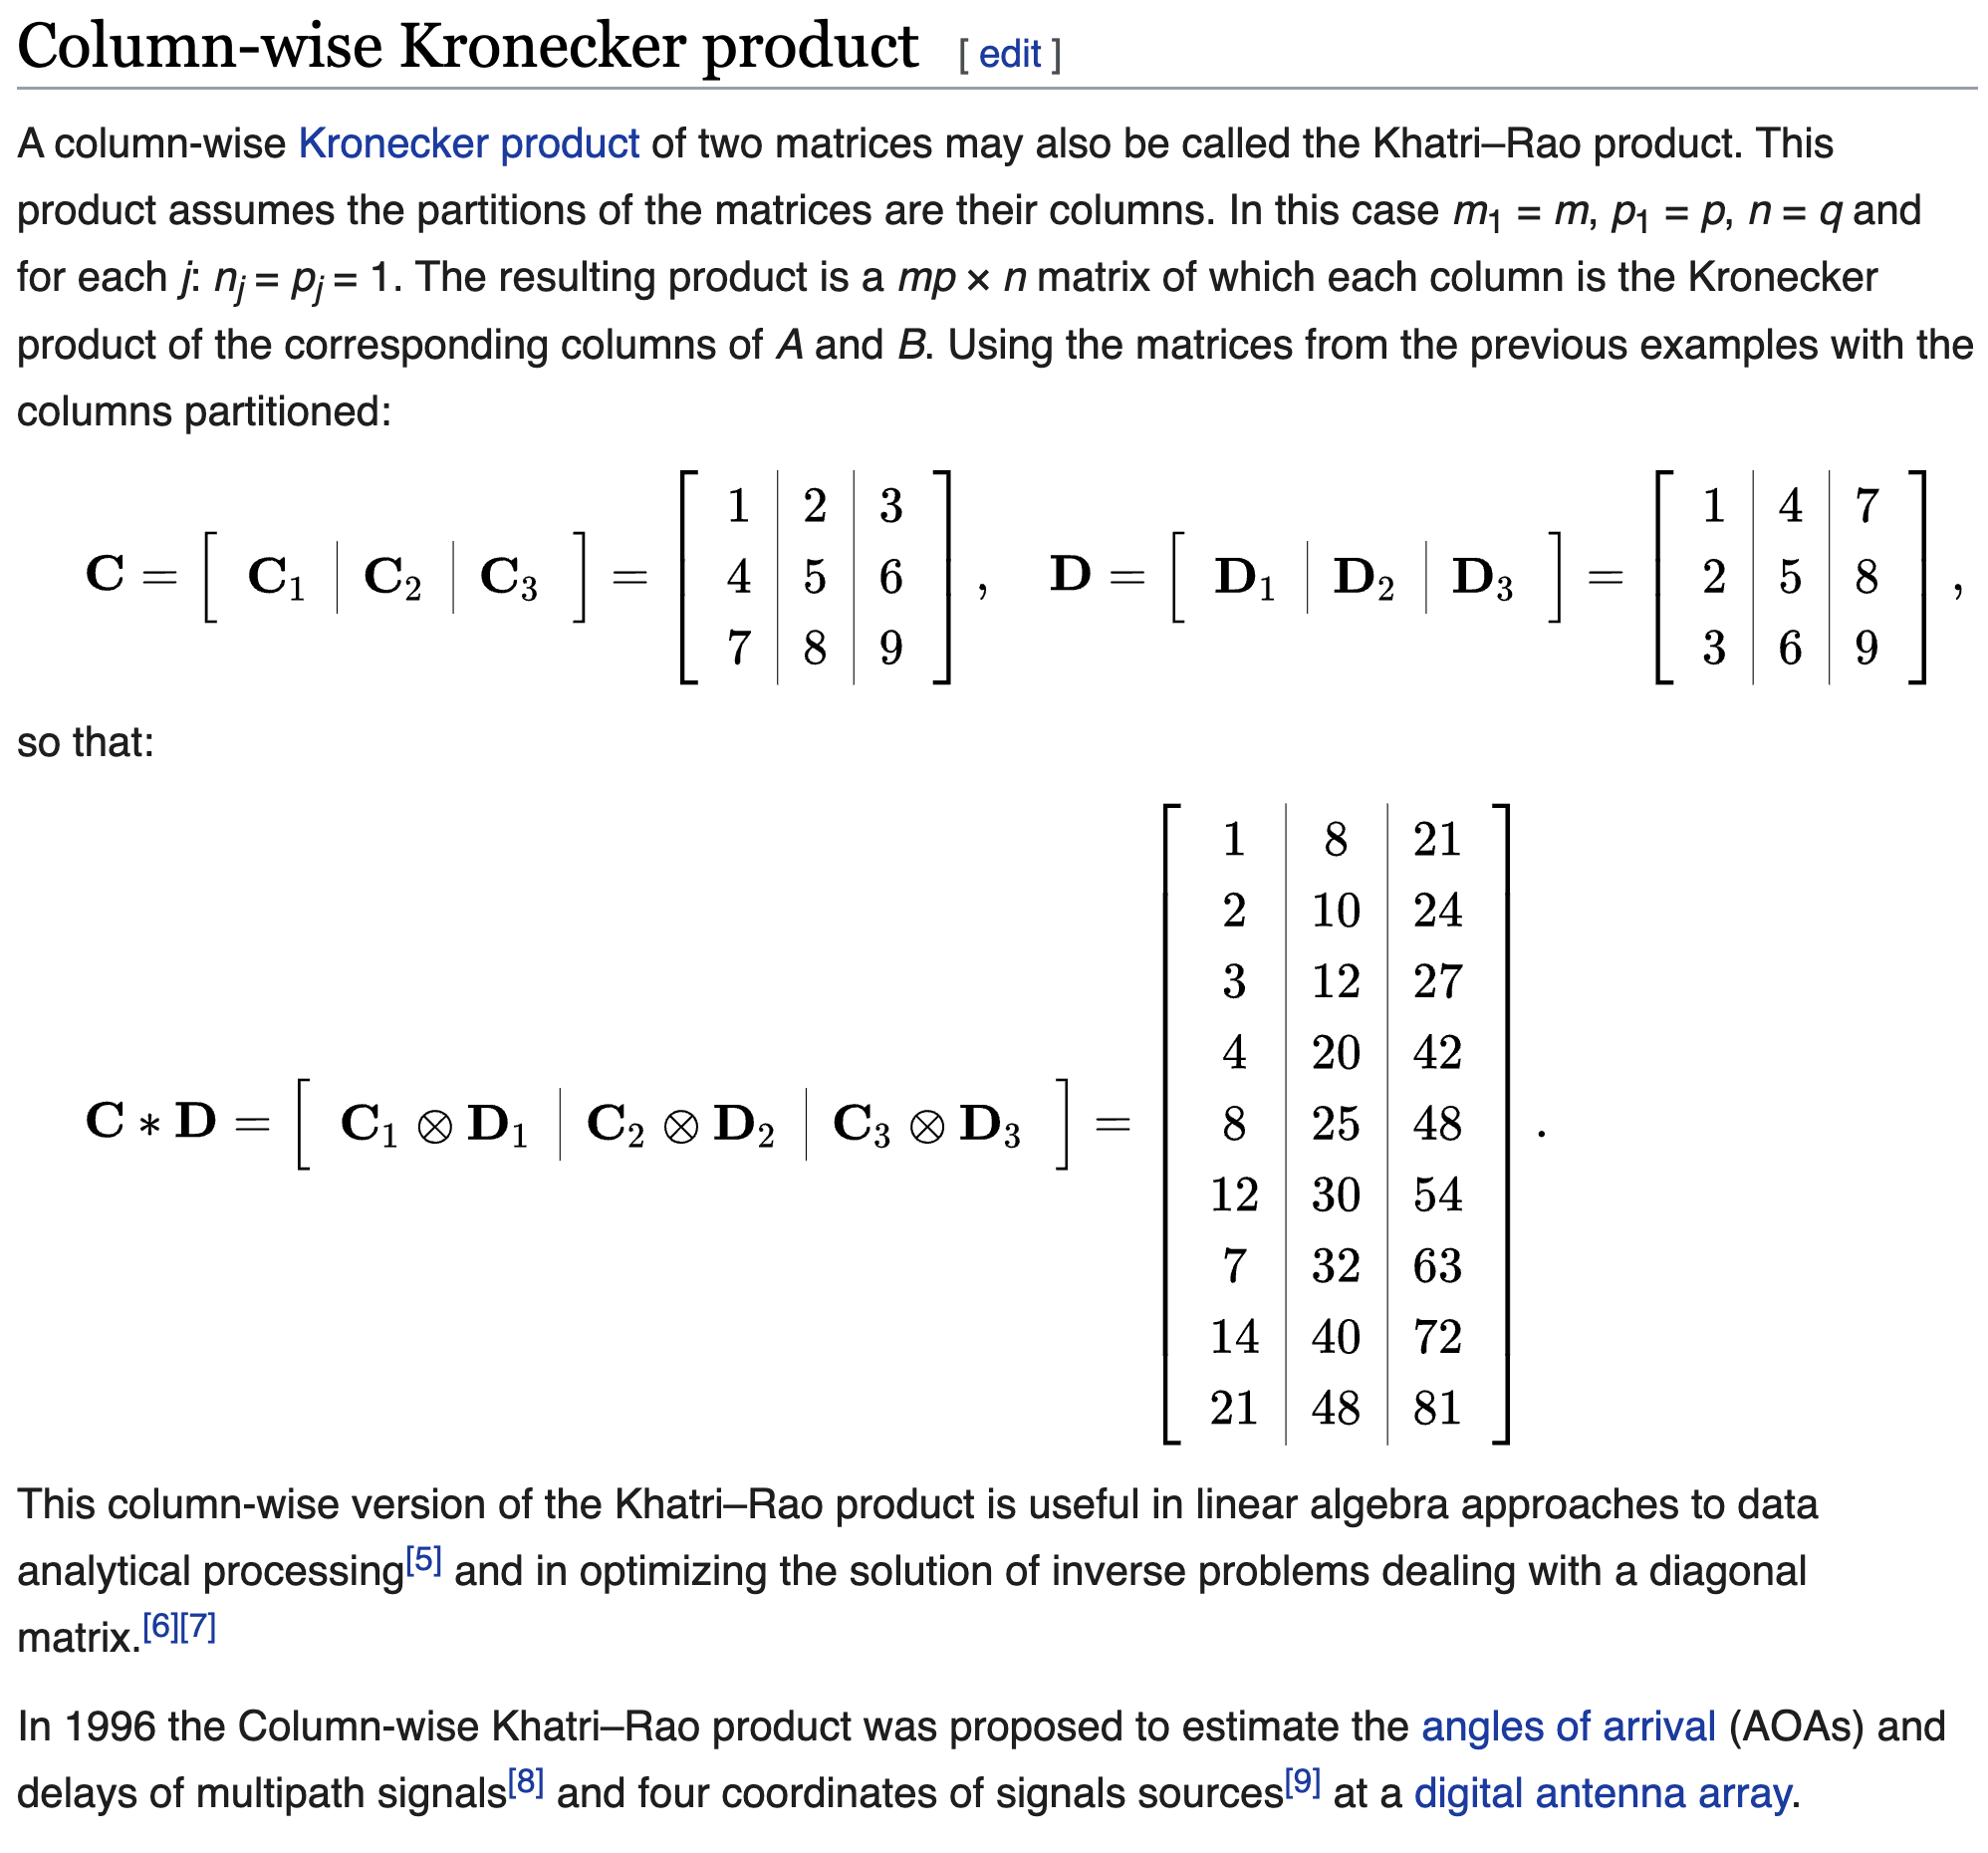
<figcaption aria-hidden="true">예시2: 위키에서 긁은 그림</figcaption>
</figure>

(예제1)

In [302]:
C= [1 2 3 
    4 5 6 
    7 8 9] 
D= [1 4 7
    2 5 8
    3 6 9]

In [303]:
hcat([kron(C[:,i],D[:,i]) for i in 1:3]...)

이건 자주 쓸일이 있을것 같으니까 함수로 저장하자.

In [304]:
columnwise_kron = 
(C,D) -> hcat([kron(C[:,i],D[:,i]) for i in 1:size(C)[2]]...)

In [305]:
columnwise_kron(C,D)

## 그래프 표현

아래의 그림을 살펴보자.

<figure>
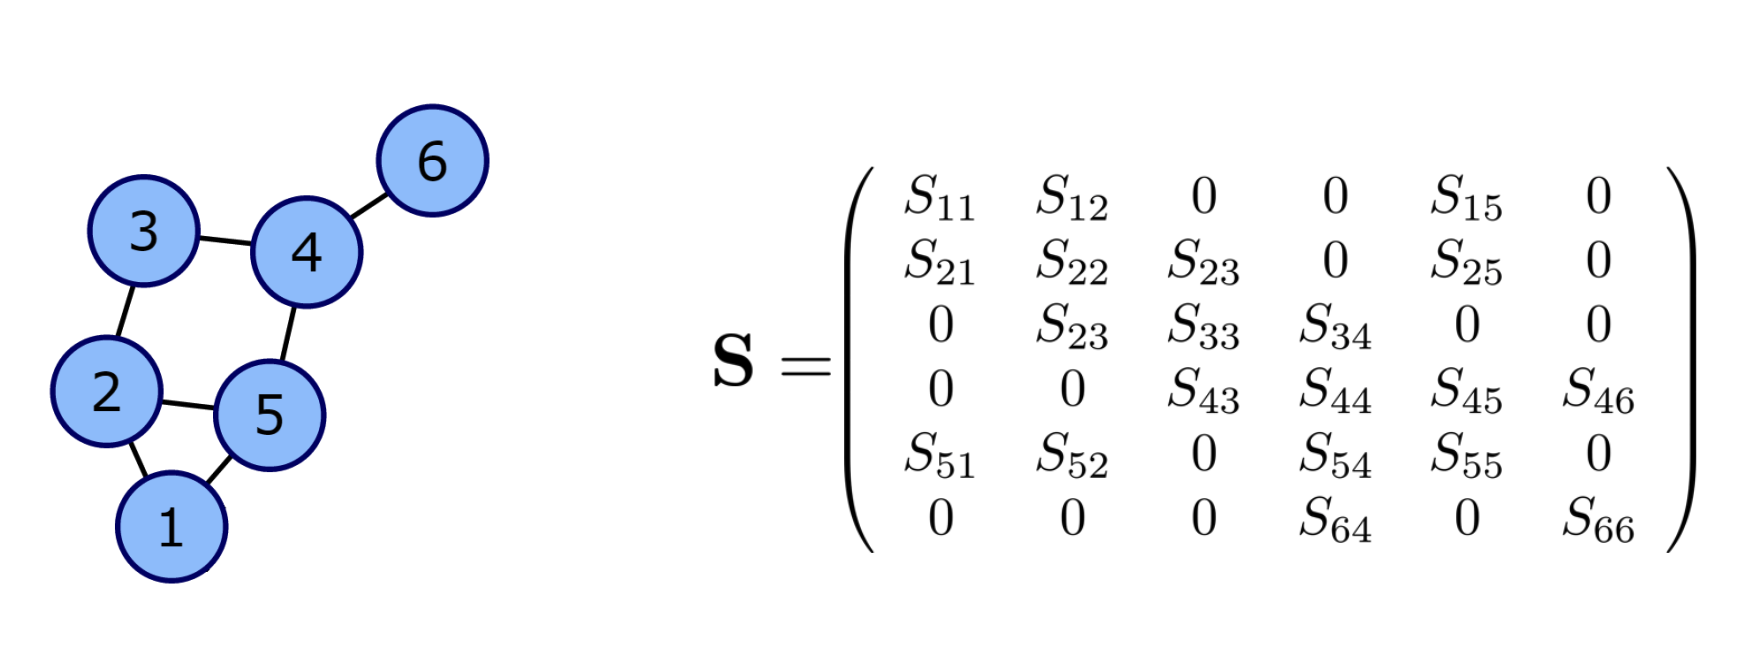
<figcaption aria-hidden="true">그래프의 개념을 이해하는 필요한 그림,
일단 오른쪽의 <span class="math inline">${\bf S}$</span>는 무시할
것</figcaption>
</figure>

오른쪽의 ${\bf S}$는 무시하고 왼쪽의 그래프만 살펴보자. 이 그림에는
6개의 노드가 있고 각각의 노드는 저 마다의 연결구조를 가진다. 이러한
연결구조는 ${\bf G}=({\bf N},{\bf E})$ 으로 표현할 수 있는데 여기에서
${\bf N}$은 노드들의 집합이고 ${\bf E}$는 엣지들의 집합이다.[1] 보통
${\cal E}$는 복잡하므로 연결정보를 매트릭스 ${\bf E}$로 표현하는데
이러한 ${\bf E}$를 인접행렬이라고 부른다. 인접행렬의 각 원소는
$E_{ij}= \begin{cases} 1 & (i,j) \in {\cal E} \\ 0 & o.w \end{cases}$ 와
같이 정의한다. 이 그림의 경우 ${\cal N}$ 와 ${\cal E}$, ${\bf E}$ 는
아래와 같다.

-   ${\cal N}=\{1,2,3,4,5,6\}$

-   ${\bf E}=\begin{bmatrix} 0 & 1 & 0 & 0 & 1 & 0 \\ 1 & 0 & 1 & 0 & 1 & 0\\ 0 & 1 & 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 \end{bmatrix}$

-   ${\cal E} = \{(i,j) : E_{ij}=1 \}$

## GSO

후에 자세히 서술하겠지만 전통적인 시계열분석기법을 그래프신호로 확장하기
위해서는 단지 퓨리에변환 대신에 그래프퓨리에 변환을 사용하면 된다. 즉
퓨리에변환을 일반화한 그래프퓨리에변환을 잘 정의하면 된다.

전통적인 신호처리 영역에서의 퓨리에변환은 시계열자료의 인접성을 의미하는
행렬 ${\bf B}$[2]의 고유행렬의 켤레전치로 정의할 수 있다. 이를 이용하면
그래프 퓨리에변환은 그래프자료의 인접성을 의미하는 행렬[3]의 고유행렬의
켤레전치로 정의할 수 있음을 유추할 수 있다. 즉 비유클리드 자료에서도
${\bf B}$에 대응하는 어떠한 매트릭스가 정의되어야 하는데 (그리고 이
매트릭스는 그래프자료의 인접성에 대한 정보가 있어야 한다) 이 매트릭스를
${\bf S}$라고 정의하고 **grahp shift operator (GSO)** 라고 이름 붙인다.

주어진 그래프 ${\cal G}=({\cal N},{\cal E})$ 에 대하여 GSO ${\bf S}$는
${\bf E}+{\bf I}$의 값이 1인 영역에만 값이 있는 어떠한 행렬이다. 다시
아래의 그림을 생각하여 보자.

<figure>
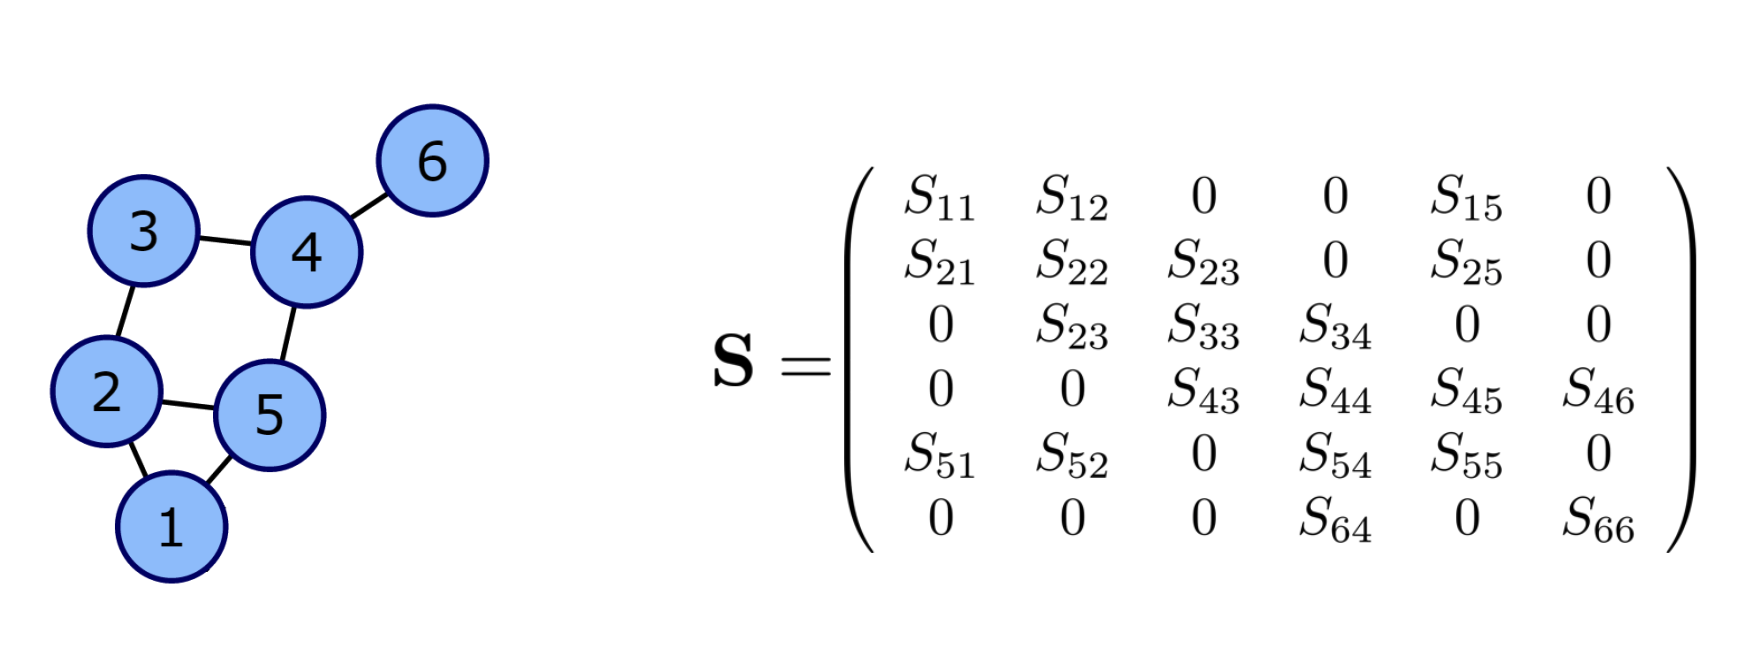
<figcaption aria-hidden="true">GSO의 개념을 이해하는데 필요한
그림</figcaption>
</figure>

왼쪽그래프의 GSO는 오른쪽과 같은 행렬 ${\bf S}$가 된다. 이제 ${\bf S}$
의 고유벡터행렬을 구한 뒤에 그것의 켤레전치를 ${\bf GFT}$ 행렬로
정의하면 될 것 같다. 문제는 “${\bf S}$의 고유벡터행렬이 항상
존재하는가?” 인데, 사실 이게 항상 존재한다는 보장이 없다. 즉 ${\bf S}$의
고유벡터 행렬이 존재 안할 수도 있다. 따라서 GSO ${\bf S}$가
고유분해가능하다는 조건이 추가적으로 필요한데 이러한 조건을 만족하는
GSO를 normal GSO라고 부른다. 우리는 당연히 normal GSO에 대해서만 관심이
있으므로 앞으로 특별한 언급이 없는한 GSO는 모두 normal GSO라고 가정한다.

# 12.2.1. Power Spectral Density

> Djuric and Richard (2018) 의 Chap 12.2.1, Chap 12.3

**Definition 12.3.** The PSD of a random process ${\bf x}$ that is
stationary with respect to GSO ${\bf S}={\bf V}{\bf \Lambda}{\bf V}^H$
is the nonnegative $N \times 1$ vector ${\bf p}$

$${\bf p}:=\text{diag}\big({\bf V}^H {\bf C}_{\bf x}{\bf V} \big).$$

OversObserve that because ${\bf C}_{\bf x}$ is diagonalized by ${\bf V}$
the matrix ${\bf V}^H{\bf C}_{\bf x}{\bf V}$ is diagonal and it follows
that the PSD in above equation corresponds to the eigenvalues of the
positive semidefinite covariance matrix ${\bf C}_{\bf x}$. Thus, above
equation is equivalent to

$${\bf C}_{\bf x}={\bf V}\text{diag}({\bf p}){\bf V}^H.$$

Zero-mean white noise is an example of a random process that is
stationary with respect to any graph shift ${\bf S}$. The PSD of white
noise with covariance $\mathbb{E}[{\bf n}{\bf n}^H] = \sigma^2{\bf I}$
is ${\bf p} = \sigma^2{\bf 1}$[4]. Also notice that, by definition, any
random process ${\bf x}$ is stationary with respect to the shift
${\bf S} = {\bf C}_{\bf x}$ defined by its covariance matrix, with
corresponding PSD ${\bf p} = \text{diag}({\bf \Lambda})$. This can be
exploited in the context of network topology inference. Given a set of
graph signals $\{{\bf x}_r\}_{r=1}^R$ it is common to infer the
underlying topology by building a graph ${\cal G}_{corr}$ whose edge
weights correspond to cross-correlations among the entries of the
signals. In that case, the process generating those signals is
stationary in the shift given by the adjacency of ${\cal G}_{corr}$; see
Segarra et al. (2017) for details. A random process x is also stationary
with respect to the shift given by its precision matrix, which is
defined as the (pseudo-)inverse
${\bf \Theta}= {\bf C}^{\dagger}_{\bf x}$. The PSD, in this case, is
${\bf p} = \text{diag}(\Lambda)^{\dagger}$. This is particularly
important when ${\bf x}$ is a Gaussian Markov Random Field (GMRF) whose
Markovian dependence is captured by the unweighted graph
${\cal G}_{MF}$. It is well known Segarra et al. (2017) Ch. 19 that in
these cases ${\bf \Theta}_{i,j}$ can be nonzero only if $(i,j)$ is
either a link of ${\cal G}_{MF}$ , or an element in the diagonal. Thus,
any GMRF is stationary with respect to the sparse shift
${\bf S} = {\bf \Theta}$, which captures the conditional dependence
between the elements of ${\bf x}$. Two important properties that hold
for random processes in time can be shown to be true as well for the PSD
of graph processes.

**Property 12.1** Let ${\bf x}$ be stationary in ${\bf S}$ with
covariance ${\bf C}_{\bf x}$ and PSD ${\bf p}_x$. Consider a filter
${\bf H}$ with frequency response $\tilde{\bf h}$ and define
${\bf y}:={\bf H}{\bf x}$. Then, the process ${\bf y}$:

1.  Is stationary in ${\bf S}$ with covariance
    ${\bf C}_{\bf y}= {\bf H}{\bf C}_{\bf x}{\bf H}^H$.

2.  Has a PSD given by
    ${\bf p}_{\bf y}=|\tilde{\bf h}|^2 \circ {\bf p}_{\bf x}$, where
    $|\cdot|^2$ is applied elementwise.

> Here $\circ$ is elementwise matrix product

**Property 12.2** Given a process ${\bf x}$ stationary in
${\bf S}={\bf V}{\bf \Lambda}{\bf V}^H$ with PSD ${\bf p}$, define the
GFT process as $\tilde{\bf x}={\bf V}^H{\bf x}$. Then, it holds that
$\tilde{\bf x}$ is uncorrelated and its covariance matrix is

$${\bf C}_{\tilde{\bf x}}:= \mathbb{E}\left[\tilde{\bf x}\tilde{\bf x}^H \right]=\mathbb{E}\left[({\bf V}^H{\bf x})({\bf V}^H{\bf x})^H \right]=\text{diag}({\bf p}).$$

Property 12.1 is a statement of the spectral convolution theorem for
graph signals. Property 12.2 is fundamental to motivate the analysis and
modeling of stationary graph processes in the frequency domain, which we
undertake in the remainder of this chapter. It also shows that if a
process ${\bf x}$ is stationary in the shift
${\bf S} = {\bf V}{\bf \Lambda}{\bf V}^H$, then the GFT ${\bf V}^H$
provides the Karhunen-Loève expansion of the process.

The concept of stationarity and, consequently, that of PSD can be
extended to processes defined jointly in a graph and over time. Before
we review this extension in the ensuing section, we discuss requirements
on the first moment of stationary graph processes.

**The mean of stationary graph processes**. While Definitions 12.1 and
12.2 assume that the random process ${\bf x}$ has mean
$\tilde{\bf x} := \mathbb{E}[{\bf x}] = {\bf 0}$, traditional stationary
time processes are allowed to have a (nonzero) constant mean
$\bar{\bf x} = \alpha{\bf 1}$, with $\alpha$ being an arbitrary scalar.
Stationary graph processes, by contrast, are required to have a
first-order moment of the form $\bar{\bf x} = \alpha {\bf v}_k$, i.e., a
scaled version of an eigenvector of ${\bf S}$. This choice: (i) takes
into account the structure of the underlying graph; (ii) maintains the
validity of Property 12.1; and (iii) encompasses the case
${\bf v}_k = {\bf 1}$ when ${\bf S}$ is either the adjacency matrix of a
directed cycle or the Laplacian of any graph, recovering the classical
first-order requirement for weak stationarity.

# 12.3. Power Spectral Density Estimators

We can exploit the fact that ${\bf x}$ is a stationary graph process in
${\bf S} = {\bf V}\text{diag}({\bf \Lambda}){\bf V}^H$ to design
efficient estimators of the covariance ${\bf C}_{\bf x}$. In particular,
instead of estimating ${\bf C}_{\bf x}$ directly, which has $N(N + 1)/2$
degrees of freedom, one can estimate ${\bf p}$ first, which only has $N$
degrees of freedom, and then leverage that
${\bf C}_{\bf x} = {\bf V}\text{diag}({\bf p}){\bf V}^H$. Motivated by
this, the focus of this section is on estimating ${\bf p}$, the PSD of a
stationary random graph process ${\bf x}$, using as input either one or
a few realizations $\{{\bf x}_r\}_{r=1}^R$ of ${\bf x}$. To illustrate
the developments in Sections 12.3 and 12.4, we will use as a running
example a random process defined on the well-known Zachary’s Karate club
network Zachary (1977) (Figs. 12.3 and 12.4). As shown in Fig. 12.4,
this graph consists of 34 nodes or members of the club and 78 undirected
edges symbolizing friendships among members.

<figure>
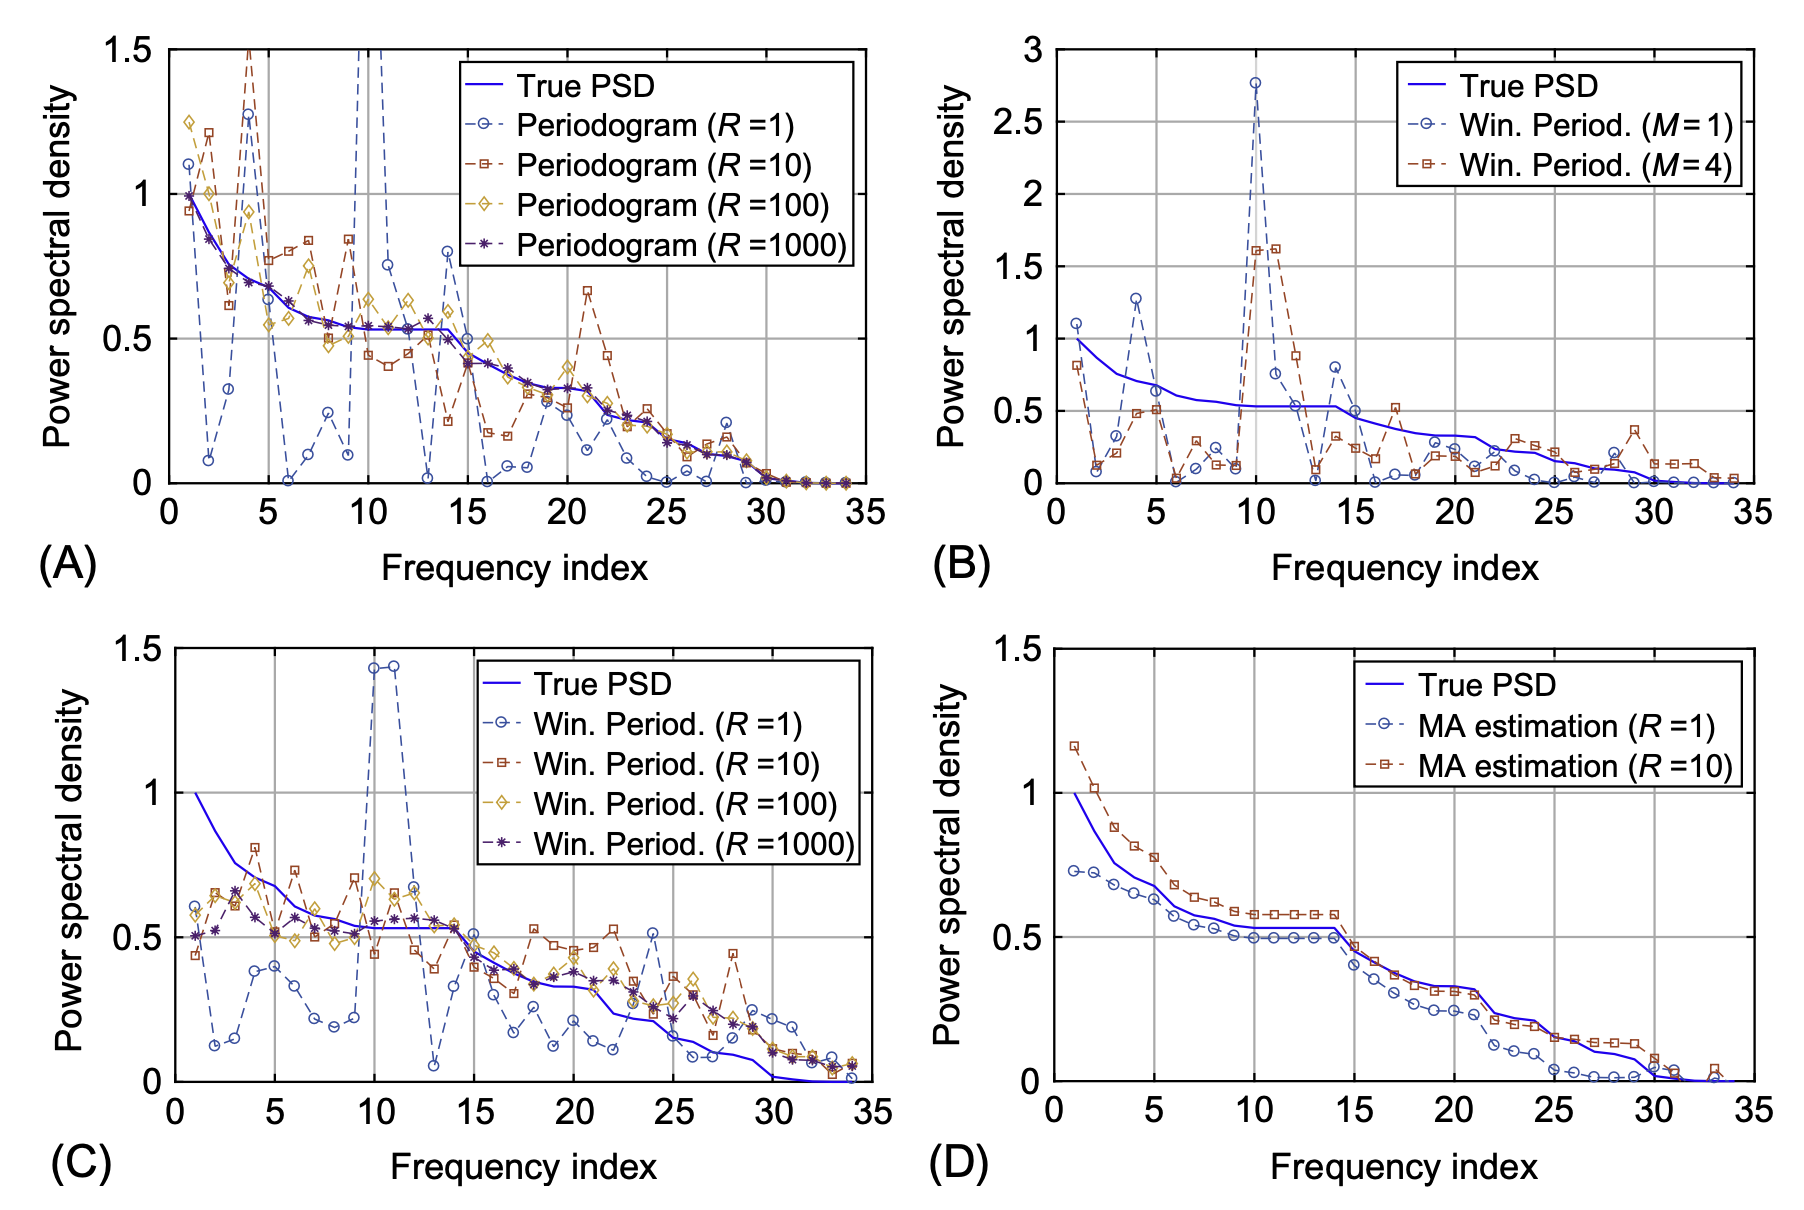
<figcaption aria-hidden="true">그림12.3(교재에서 긁어온 그림): Power
spectral density estimation. All estimators are based on the same random
process defined on the Karate club network <span class="citation"
data-cites="zachary1977information">(Zachary 1977)</span>. (A)
Periodogram estimation with different numbers of observations. (B)
Windowed average periodogram from a single realization and a different
number of windows. (C) Windowed average periodogram for four windows and
a varying number of realizations. (D) Parametric MA estimation for 1 and
10 realizations.</figcaption>
</figure>

<figure>
<img
src="attachment:2022-12-27-Chap-12.2.1~12.3.1_files/figure-ipynb/871b9550-848f-4d49-9a99-26a5c2d85595-1-f9528ecc-9143-4e3b-bff7-18e4b23a9651.png"
alt="그림12.4(교재에서 긁어온 그림): PSD estimation from a subset of nodes. Estimators are based on a random process defined on the Karate club network (Zachary 1977). (A) Graph sampling for nonparametric PSD estimation. Here, 20 out of 34 nodes are observed. The sampled nodes are highlighted by the circles around the nodes. (B) Nonparametric PSD estimation based on observations from 20 nodes and 100 data snapshots. (C) Graph sampling for parametric MA PSD estimation. Here, 4 out of 34 nodes are observed. (D) Parametric MA PSD estimation based on observations from 4 nodes and 100 data snapshots." />
<figcaption aria-hidden="true">그림12.4(교재에서 긁어온 그림): PSD
estimation from a subset of nodes. Estimators are based on a random
process defined on the Karate club network <span class="citation"
data-cites="zachary1977information">(Zachary 1977)</span>. (A) Graph
sampling for nonparametric PSD estimation. Here, 20 out of 34 nodes are
observed. The sampled nodes are highlighted by the circles around the
nodes. (B) Nonparametric PSD estimation based on observations from 20
nodes and 100 data snapshots. (C) Graph sampling for parametric MA PSD
estimation. Here, 4 out of 34 nodes are observed. (D) Parametric MA PSD
estimation based on observations from 4 nodes and 100 data
snapshots.</figcaption>
</figure>

# 12.3.1. Nonparametric PSD estimators

Nonparametric estimators—as opposed to their parametric counterparts—do
not assume any specific generating model on the process ${\bf x}$. This
more agnostic view of ${\bf x}$ comes with the price of needing, in
general, to observe more graph signals to achieve satisfactory
performance. In this section, we extend to the graph setting the
periodogram, the correlogram, and the least-squares (LS) estimator,
which are classical unbiased nonparametric estimators. Moreover, for the
special case where the observations are Gaussian, we derive the
Cramér-Rao lower bound. We also discuss the windowed average
periodogram, which attains a better performance when a few observations
are available by introducing bias in a controlled manner while
drastically reducing the variance.

## Periodogram, correlogram, and LS estimator

From
${\bf C}_{\tilde{\bf x}}:= \mathbb{E}\left[\tilde{\bf x}\tilde{\bf x}^H \right]=\mathbb{E}\left[({\bf V}^H{\bf x})({\bf V}^H{\bf x})^H \right]=\text{diag}({\bf p})$
it follows that one may express the PSD as
${\bf p}=\mathbb{E}\left[|{\bf V}^H{\bf x}|^2\right]$. That is, the PSD
is given by the expected value of the squared frequency components of
the random process. This leads to a natural approach for the estimation
of ${\bf p}$ from a finite set of $R$ realizations of the process
${\bf x}$. Indeed, we compute the
${\bf GFT} \tilde{\bf x}_r = {\bf V}^H{\bf x}_r$ of each observed signal
${\bf x}_r$ and estimate ${\bf p}$ as

$$
\hat{\bf p}_{pg}:= \frac{1}{R}\sum_{r=1}^R|\tilde{\bf x}_r|^2=\frac{1}{R}\sum_{r=1}^{R}|{\bf V}^H{\bf x}_{r}|^2.
$$

The estimator $\hat{\bf p}_{pg}$ is termed periodogram due to its
evident similarity with its homonym[5] in classical estimation. It is
simple to show that ${\bf p}_{pg}$ is an unbiased estimator, that is,
$\mathbb{E}[\hat{\bf p}_{pg}]= {\bf p}$. A more detailed analysis of the
performance of $\hat{\bf p}_{pg}$, for the case where the observations
are Gaussian, is given in Proposition 12.1.[6]

An alternative nonparametric estimation scheme, denominated correlogram,
can be devised by starting from the definition of ${\bf p}$ in

$${\bf p}:=\text{diag}\big({\bf V}^H {\bf C}_{\bf x}{\bf V} \big).$$

Namely, one may substitute ${\bf C}_{\bf x}$ in above equation by the
sample covariance
$\hat{\bf C}_{\bf x} = \frac{1}{R}\sum_{r=1}^R{\bf x}_r{\bf x}_r^H$
computed based on the available observations to obtain

$$\hat{\bf p}_{cg}:= \text{diag}\left({\bf V}^H \hat{\bf C}_{\bf x}{\bf V} \right):=\text{diag}\left[{\bf V}^H\big[ \frac{1}{R}\sum_{r=1}^R{\bf x}_r{\bf x}_r^H\big]{\bf V} \right].$$

Notice that the matrix ${\bf V}^H\hat{\bf C}_{\bf x}{\bf V}$ is in
general, not diagonal because the eigenbasis of $\hat{\bf C}_{\bf x}$
differs from ${\bf V}$, the eigenbasis of ${\bf C}_{\bf x}$.
Nonetheless, we keep only the diagonal elements
${\bf v}_i^H \hat{\bf C}_{\bf x}{\bf v}_i$ for $i = 1, \dots , N$ as our
PSD estimator. It can be shown that the correlogram ${\bf p}_{cg}$ and
the periodogram ${\bf p}_{pg}$ lead to identical estimators, as is the
case in classical signal processing.

The correlogram can also be interpreted as an LS estimator. The
decomposition in ${\bf C}_{\bf x}={\bf V}\text{diag}({\bf p}){\bf V}^H$
allows a linear parameterization of the covariance matrix
${\bf C}_{\bf x}$ as

$$ 
{\bf C}_{\bf x}({\bf p})=\sum_{i=1}^N p_i{\bf v}_i{\bf v}_i^H.
$$

This linear parametrization will also be useful for the sampling schemes
developed in Section 12.4. Vectorizing ${\bf C}_{\bf x}$ in
${\bf C}_{\bf x}({\bf p})=\sum_{i=1}^N p_i{\bf v}_i{\bf v}_i^H$ results
in a set of $N^2$ equations in ${\bf p}$

$$
{\bf c}_{\bf x} = \text{vec}({\bf C}_{\bf x})=\sum_{i=1}^{N}p_i \text{vec}({\bf v}_i{\bf v}_i^H)={\bf G}_{np}{\bf p},
$$

where
$\text{vec}({\bf v}_i{\bf v}_i^H)={\bf v}_i^\ast \otimes {\bf v}_i$.
Relying on the Khatri-Rao product, we then form the $N^2 \times N$
matrix ${\bf G}_{np}$ as

$$
{\bf G}_{np}:= \left[{\bf v}_1^\ast \otimes {\bf v}_1, \dots, {\bf v}_N^\ast \otimes {\bf v}_N \right] = {\bf V}^\ast \odot {\bf V}.
$$

> Here $\otimes$ denote the Kronecker matrix product and $\odot$ denote
> the Khatri-Rao matrix product.

Using the sample covariance matrix $\hat{\bf C}_{\bf x}$ as an estimate
of ${\bf C}_{\bf x}$, we can *match* the estimated covariance vector
$\hat{\bf c}_{\bf x}=\text{vec}(\hat{\bf C}_{\bf x})$ to the true
covariance vector ${\bf c}_{\bf x}$ in the LS sense as

$$
\hat{\bf p}_{ls} = \underset{\bf p}{\operatorname{argmin}} \|\hat{\bf c}_{\bf x}-{\bf G}_{np}{\bf p}\|_2^2=({\bf G}_{np}^H{\bf G}_{np})^{-1}{\bf G}_{np}^H\hat{\bf c}_{\bf x}.
$$

In other words, the LS estimator minimizes the squared error
$\text{tr}\left[\big(\hat{\bf C}_{\bf x} − \hat{\bf C}_{\bf x}({\bf p})\big)^T \big(\hat{\bf C}_{\bf x} − \hat{\bf C}_{\bf x}({\bf p})\big)\right]$.
From expression
$\hat{\bf p}_{ls} = \underset{\bf p}{\operatorname{argmin}} \|\hat{\bf c}_{\bf x}-{\bf G}_{np}{\bf p}\|_2^2=({\bf G}_{np}^H{\bf G}_{np})^{-1}{\bf G}_{np}^H\hat{\bf c}_{\bf x}$
it can be shown that the $i$th element of $\hat{\bf p}_{ls}$ is
${\bf v}_i^H \hat{\bf C}_{\bf x} {\bf v}_i$. Combining this with Eq.

$$\hat{\bf p}_{cg}:= \text{diag}\left({\bf V}^H \hat{\bf C}_{\bf x}{\bf V} \right):=\text{diag}\left[{\bf V}^H\big[ \frac{1}{R}\sum_{r=1}^R{\bf x}_r{\bf x}_r^H\big]{\bf V} \right]$$

we get that the LS estimator $\hat{\bf p}_{ls}$ and the correlogram
$\hat{\bf p}_{cg}$ —and hence the periodogram as well— are all identical
estimators. The estimators derived in this subsection do not assume any
data distribution and are well suited for cases where the data
probability density function is not available. In what follows, we
provide performance bounds for these estimators under the condition that
the observed signals are Gaussian.

# Summary

## 정상시계열을 분석하는 두 가지 흐름, ACF와 PSD

### 전통적인 분석방법

클래식한 정상시계열은 유한차수의 ARMA로 근사할 수 있음이 알려져 있다[7].
유한차수의 ARMA의 계수 $p$,$q$를 적절하게 추정하기 위해서는 시계열
${\bf x}$를 SACF plot 혹은 SPACF plot 을 이용하면 된다. 이때 SACF 혹은
SPACF 의 그림을 살펴보고 적절한 모형을 선택하기 위해서는 유한차수 ARMA의
이론적 ACF의 모양을 알면 되는데,[8] 이를 바꾸어서 말하면 결국 정상시계열
${\bf x}$의 모든 정보는 ACF에 들어있다는 의미가 된다. 즉 정상시계열은
ACF만 잘 추정하면 모든 것이 해결된다.

그런데 ACF의 모든 정보는 다시 아래의 행렬에 들어있다.

$${\bf C}_{\bf x}=\mathbb{E}[{\bf x}{\bf x}^T]$$

여기에서 ${\bf x}$는 realization이 아니라 확률벡터를 의미함을
유의하자.[9] 따라서 정상시계열의 경우 ${\bf C}_{\bf x}$를 잘 추정하면
모든것이 해결된다고 생각하면 된다.

> 참고: 정상시계열의 경우 ACF 만 정확하게 알아도 (반대로 PACF만 정확하게
> 알아도) 이론상 모든 모형을 특정할 수 있다. 즉 정상시계열의 모형을
> 특정하기 위해서는 ACF plot, PACF plot 하나만 있어도 충분하다. (Wold’s
> Thm은 떠올리면 모든 정상시계열은 무한MA로 유니크하게 표현할 수 있는데,
> 이는 PACF plot을 가지고 모든 정상시계열을 유니크하게 특정할 수 있다는
> 것을 의미한다) 다만 좀 더 모형을 특정하는 과정을 용이하게 하기 위해서
> 실전에서는 SACF plot 과 SPACF plot 을 함께 보는 것이 유리하다.

**(예제) AR(1) 모형**

왜 ACF의 모든정보를 ${\bf C}_{\bf x}$로 부터 알수 있는지 코드를 통하여
실습하여 보자. (바로 이해된다면 사실 이 예제는 스킵해도 무방함) 아래와
같은 모형을 가정하자.

$$x_{t} = 0.5 x_{t-1} +\epsilon_t$$

여기에서 $\epsilon_t$는 서로 독립인 표준정규분포를 따른다. 이 모형에서
길이가 100인 시계열을 임의로 발생시키자.

[1] 노드 $i$에서 노드 $j$로 향하는 연결이 있다면
$(i,j) \in {\cal E}$이다.

[2] 원래는 평행이동을 의미하는 행렬이지만, 이걸 인접성을 의미하는 행렬로
해석할 수도 있다. 어차피 인접한 곳으로 이동할 수 있으니까..

[3] 예를들면 인접행렬 ${\bf E}$와 같은 행렬

[4] ${\bf 1}$ is length $N$ vector with all elements are 1

[5] 동음이의어

[6] Proposition 12.1은 뒤에 다루는데 $\hat{\bf p}_{pg}$의 분산에 대한
서술이 있음. 분산은
$\mathbb{V}[\hat{\bf p}_{pg}]=\frac{2}{R}\text{diag}^2({\bf p})$와 같음

[7] Wold’s theorem

[8] 예를들어 “coef가 0.9인 AR(1)의 경우 lag=1 에 대한 이론적 ACF값이
0.9, lag=2에 대한 ACF값이 0.81, … 와 같이 되더라~” 하는식의

[9] 보통 수리통계에서는 확률변수를 $X$ realization을 $x$로 표현하지만
여기에서는 매트릭스를 대문자로 쓰고 있어서 그런식으로 표현하기 어렵다,
그래서 그때 그때 이것이 확률변수인지 realization인지 따져봐야 한다
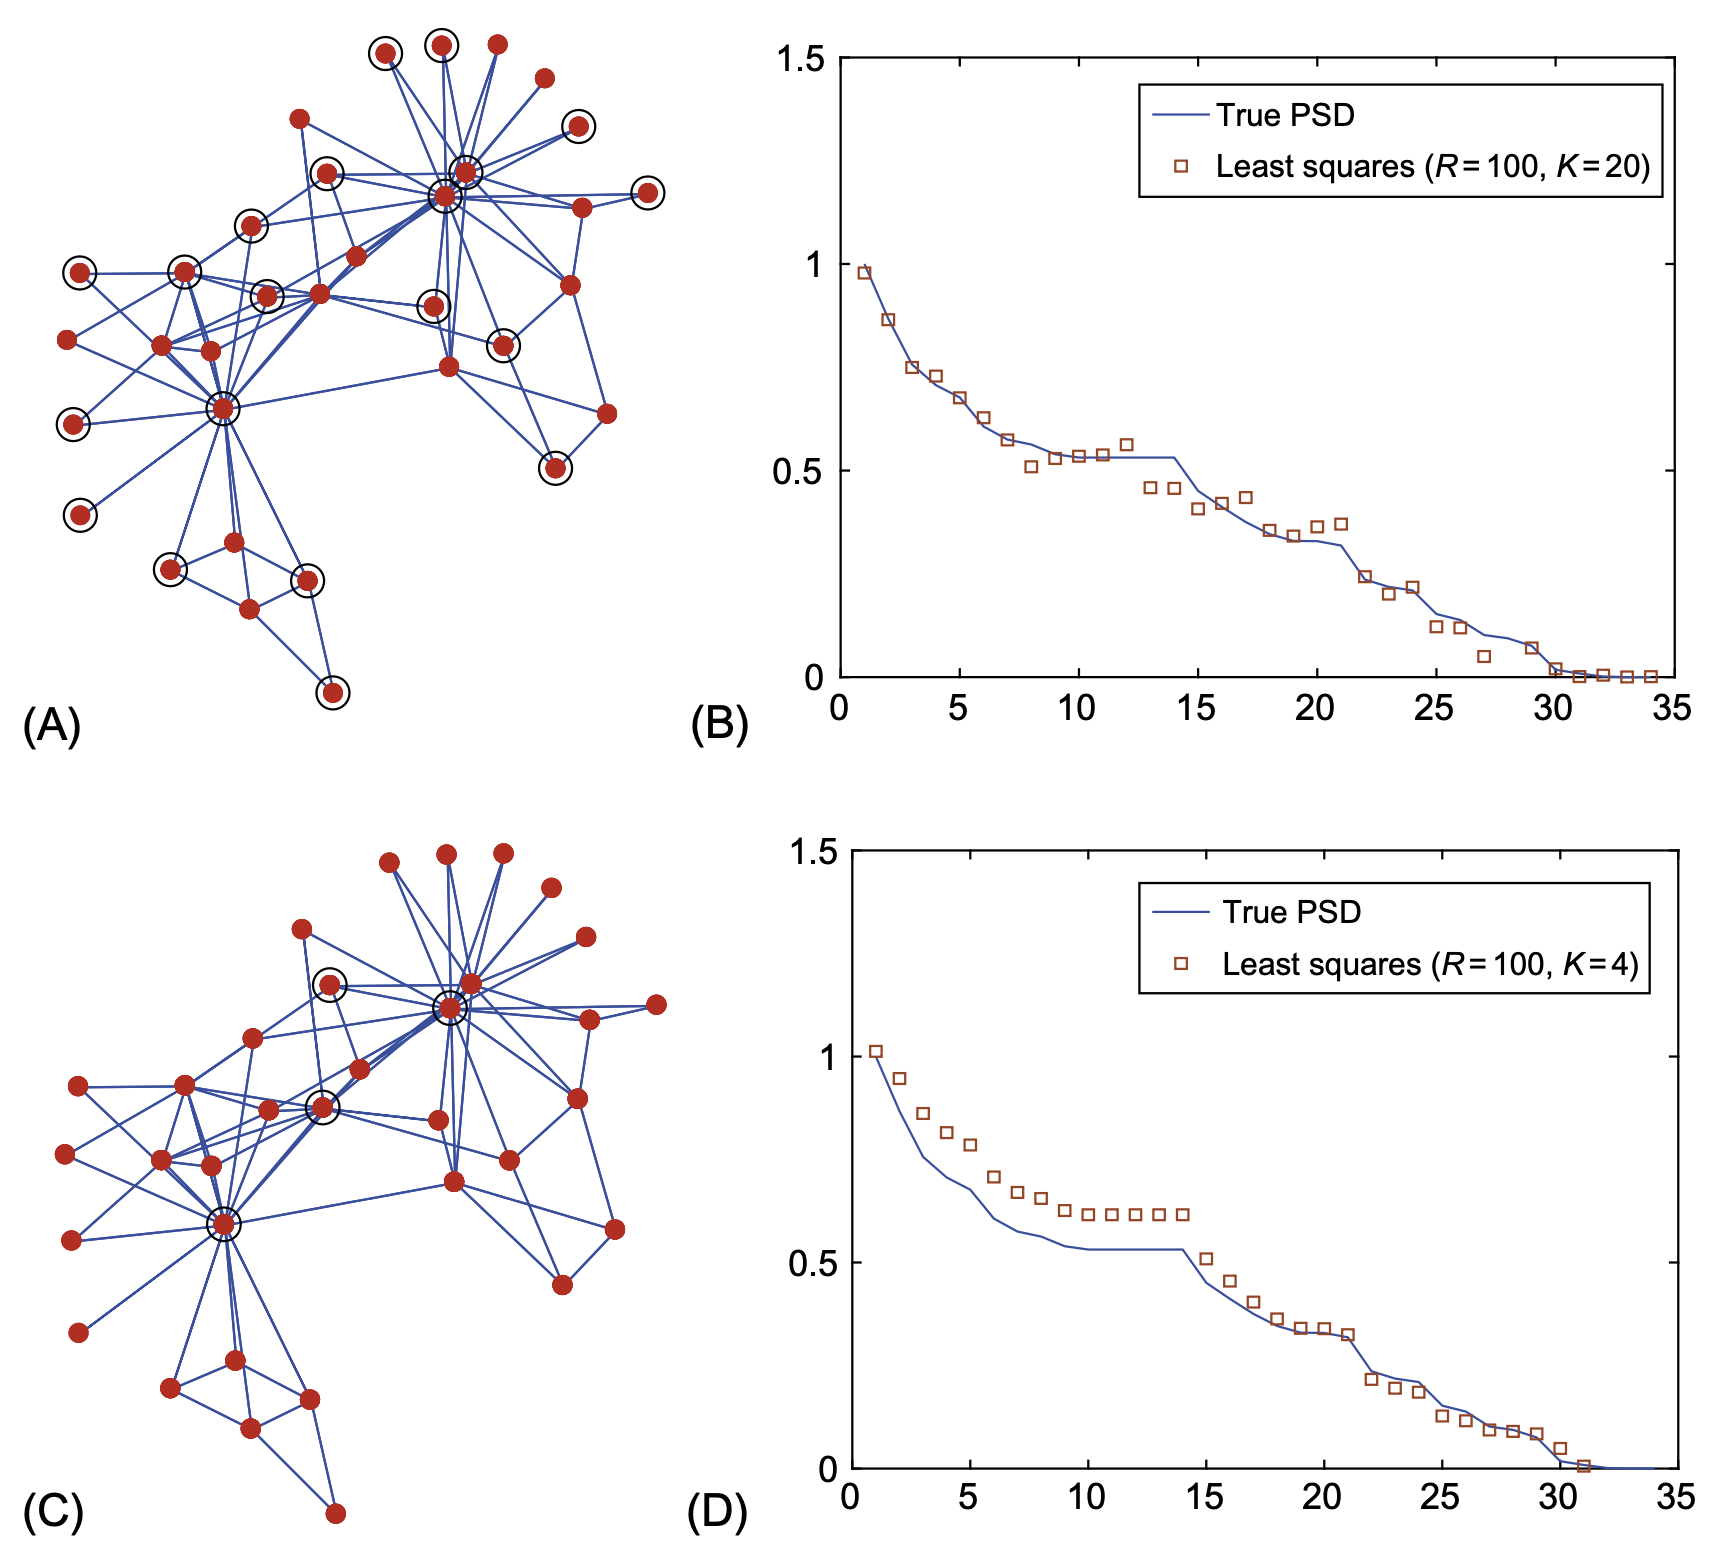

In [1]:
x = zeros(100*1000)
x[1] = randn()
for t in 2:100
    x[t] = 0.5*x[t-1] + randn()
end

모형에서 생성된 하나의 시계열을 시각화 하면 아래와 같다.

In [463]:
plot(x) # 그냥 그려본것임. 별 의미는 없음

**lag=1일 경우 이 시계열의 SACF를 계산하면 아래와 같다.**

In [464]:
x[1:99] .* x[2:100]

-   이 계산결과는 각 $t$에 대하여 $x_{t-1}x_t$ 를 계산한 것과 같다.

이 수열들의 평균은 아래와 같다.

In [465]:
x[1:99] .* x[2:100] |> mean

-   이 계산결과는 $\frac{1}{99}\sum_{t=2}^{100} x_{t-1}x_t$를 계산한
    것과 같다.

이론적인 값인 0.5 근처의 값이 잘 나옴을 알 수 있다.

**lag=2일 경우도 마찬가지로 구할 수 있다.**

In [466]:
x[1:98] .* x[3:100] |> mean

이러한 숫자들은 그런데 ${\bf x}{\bf x}^T$를 이용하여서도 구할 수
있다.[1]

[1] 참고로 여기에서 ${\bf x}$는 확률벡터가 아니라 realization을 의미함

In [467]:
x*x'

여기에서 각 원소들이 의미하는 바는 아래와 같다.

-   대각선의 원소: $x_t^2,~ t=1,2,\dots,100$ 을 의미
-   대각선 한칸 위, 혹은 한칸 아래: $x_{t-1} x_t~ t=2,3,\dots,100$ 을
    의미
-   대각선 두칸 위, 혹은 두칸 아래: $x_{t-2} x_t~ t=3,4,\dots,100$ 을
    의미

<figure>
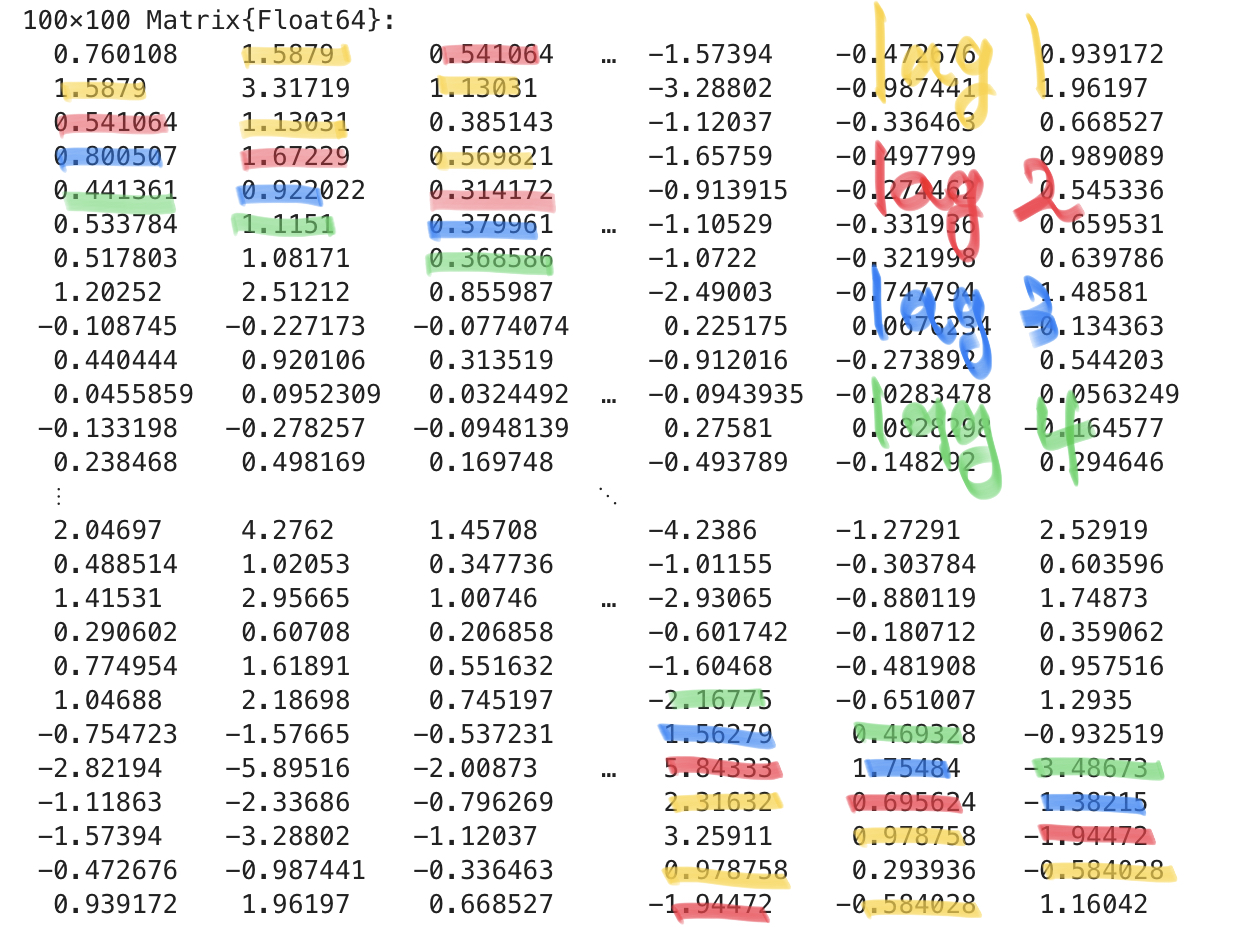
<figcaption aria-hidden="true"><code>x*x'</code>의 계산결과를 캡쳐한
그림, 이것은 <span class="math inline">$\hat{\bf C}_{\bf x}$</span>를
의미함</figcaption>
</figure>

확인해보자.

**lag=1, 스크린샷의 노란색**

In [456]:
(x[1:99] .* x[2:100])[1:5]

-   lag1에 해당하는 숫자들임. 이는 스크린샷에서 노란색으로 표현된 1.589,
    1.13031, 0.569821 … 등과 일치한다.

**lag=2, 스크린샷의 빨간색**

In [468]:
(x[1:98] .* x[3:100])[1:5]

-   lag2에 해당하는 숫자들임. 이는 스크린샷에서 빨간색으로 표현된
    숫자들인 0.54164, 1.67229, 0.31417 … 등과 일치한다.

### 스펙트럼 방법

지금까지는 정상시계열일 경우 ACF를 이용한 간단한 분석방법을 다시
복습했다. 그리고 ${\bf C}_{\bf x}$가 ACF를 구함에 필요한 모든정보를
가지고 있음을 이해했다. 한편 ${\bf C}_{\bf x}$은 positive definite
matrix 이므로 아래와 같이 분해가능하다.

$${\bf C}_{\bf x} = {\bf V} \text{diag}({\bf p}) {\bf V}^H$$

이 수식표현을 잘 해석하면 ${\bf C}_{\bf x}$의 모든 정보는 ${\bf V}$와
${\bf p}$에 담겨있다는 사실을 이해할 수 있다. 그런데 정상시계열일 경우
한정하여 ${\bf C}_{x}$의 고유벡터행렬은 ${\bf B}$의 고유벡터행렬과
일치한다는 사실을 알고 있다. 따라서 ${\bf V}$는 ${\bf B}$로 부터 그냥 알
수 있는 정보이다. 따라서 ${\bf C}_{\bf x}$의 모든 정보는 ${\bf p}$에
담겨있다는 사실을 알 수 있다. 이는 적절한 ${\bf p}$를 추정하는 일은
적절한 ${\bf C}_{\bf x}$를 추정하는 것과 같다는 사실을 알려준다.

요약하면 아래와 같다.

-   임의의 정상시계열은 이론적인 ACF (혹은 PACF)를 잘 추정하면
    유니크하게 특정할 수 있다. (Wold’s Thm)
-   ACF를 잘 추정한다는 말은 ${\bf C}_{\bf x}$를 잘 추정한다는 의미이다.
-   그런데 ${\bf p}$를 잘 추정하면 ${\bf C}_{\bf x}$를 잘 추정하는 일이
    된다.
-   따라서 임의의 정상시계열은 ${\bf p}$를 잘 추정하면 유니크하게 특정할
    수 있다는 결론을 얻는다.

여기에서 ${\bf p}$를 power spectral density 라고 부른다. 일반적으로
정상시계열을 분석하기 위해서는 ${\bf C}_{\bf x}$를 특정하거나,
${\bf p}$를 특정하면 되는데 여기에서 ${\bf p}$를 특정한뒤 ${\bf p}$로
부터 ${\bf C}$를 역으로 해석하는 방법론을 spectral analysis라고 부른다.
경우에 따라서 ${\bf C}_{\bf x}$를 특정하는 것이 용이할 수도 있지만
${\bf p}$를 특정하고 해석하는 것이 용이할 때도 있다.

그렇다면 주어진 시계열 ${\bf x}$에 대하여 ${\bf p}$를 어떻게 구할까?
직관적으로 생각하면 단순히 아래의 알고리즘으로 구하면 된다는 것을 알 수
있다.

1.  ${\bf C}_{\bf x}$를 알아낸다.
2.  ${\bf C}_{\bf x}$를 고유분해하여 ${\bf p}$를 구한다.

또 다른 방법으로는 교재에 소개된 바 있는 아래의 수식을 이용하는
것이다.[1]

$${\bf p}=\mathbb{E}\left[|{\bf V}^H{\bf x}|^2\right]$$

이것을 이용하면 아래와 같은 알고리즘을 떠올릴 수 있다.

1.  ${\bf B}$의 고유벡터행렬 ${\bf V}$를 구하고 ${\bf V}^H{\bf x}$를
    계산한다.
2.  계산된 결과를 원소별로 제곱하여 ${\bf p}$를 얻는다.

그런데 ${\bf V}^H{\bf x}= {\bf DFT} \cdot {\bf x}$ 이므로 1의 과정을
아래와 같이 바꾸어 서술할 수 있다.

1.  ${\bf x}$를 퓨리에변환하여 $\tilde{\bf x} = {\bf DFT} \cdot {\bf x}$
    를 계산한다.
2.  $\tilde{\bf x}$를 원소별로 제곱하여 ${\bf p}$를 얻는다.

즉 임의의 시계열을 퓨리에변환한 뒤 제곱하면 ${\bf p}$를 얻을 수 있다.

**(예제2) – 하나의 realization에서 $\hat{\bf p}$를 구해보자.**

(예제1에 이어서) 아래의 모형에서 생성된 ${\bf x}$를 다시 고려하자.

$$x_{t} = 0.5 x_{t-1} +\epsilon_t$$

[1] 이 수식이 성립하는 이유는 조금 손으로 써보면 금방 알 수 있음

In [476]:
plot(x)

이 자료의 PSD ${\bf p}$는 아래와 같이 구할 수 있다.

**단계1**: ${\bf x}$의 DFT를 계산

In [494]:
x̃ = fft(x) 

-   ${\bf B}$를 설정하고 고유값분해 하기 귀찮아서 그냥 DFT해주는 패키지
    사용함

**단계2**: $\hat{\bf p}$를 계산

In [498]:
p̂ = abs.(x̃).^2

***참고***

`fft(x)` 대신에 아래의 코드를 이용해도 된다.

In [554]:
N = 100 
V = [i*j for i in 0:(N-1) for j in 0:(N-1)] |> 
    x -> reshape(x,(N,N)) .|> 
    x -> exp(im * (2π/N) * x)
V'x

진짜 똑같은지 확인

In [555]:
fft(x)

### 전통적인 방법과 스펙트럼 방법의 비교

시계열자료의 전통적인 분석과 spectral analysis는 대충 아래의 과정으로
비교 설명할 수 있다.

| 단계 |                     전통적인 방법                      |                 스펙트럴 분석                 |
|:----------------------:|:----------------------:|:----------------------:|
|  1   |               ${\bf x}$의 plot을 그려봄                |           ${\bf x}$의 plot을 그려봄           |
|  2   |            SACF plot, SPACF plot 을 그려봄             |               PSD plot을 그려봄               |
|  3   | ACF를 추정 (=ARMA($p$,$q$)에 대응하는 파라메터를 추정) |               ${\bf p}$를 추정                |
|  4   |     추정된 파라메터를 바탕으로 여러가지 분석 수행      | 추정된 파라메터를 바탕으로 여러가지 분석 수행 |

눈여겨 볼 점은 PSD plot의 존재이다. 전통적인 시계열에서 SACF plot 과
비슷하게 스펙트럼 방법에서 시계열을 분석하기 위해 필요한 매우 중요한
시각화 이다. 간단하게 비교를 하면 아래와 같다.

**SACF plot**

-   x축: lag=0, lag=1, ….
-   y축: lag에 대응하는 상관계수값

**PSD plot**

-   x축: $\Omega=\big\{\frac{k}{N}:~ \text{for}~ k=0,\dots, N-1\big\}$,
    정규화된 freq를 의미함
-   y축: 주파수에 대응하는 power값

전통적인 방법에 비하여 스펙트럴 분석이 가지는 장점은 위의 표에서 소개한
일반적인 분석루틴이 시계열이 아닌 그래프신호로 쉽게 확장가능 하다는
점이다[1]. 따라서 앞으로는 전통적인 시계열 분석방법 대신 스펙트럴
분석만을 다룰 것이다. 스펙트럴 분석의 핵심적인 부분은 ${\bf p}$를
추정하는 방법과 추정량의 점근적 성질들을 파악하는 것이다. 이
포스트에서는 ${\bf p}$를 추정하는 방법만을 다룬다.

## 그래프신호에서의 PSD의 추정

이제 그래프 신호에서 ${\bf p}$를 추정하는 방법에 대하여 살펴보자.
그래프이동변환 (Graph Shift Operator, GSO)[2]
${\bf S}={\bf V}{\bf \Lambda}{\bf V}^H$에 대하여 정상인 시계열
${\bf x}$를 고려한다. 이 신호의 그래프퓨리에 변환[3]은 아래와 같이 구할
수 있다.

$$\tilde{\bf x}={\bf GFT} {\bf x} = {\bf V}^H{\bf x}$$

여기에서 $\tilde{\bf x}$를 ${\bf x}$의 주파수응답(frequency
representation)이라고 부른다.[4] 우리는 아래의 수식에서 ${\bf p}$의 값에
관심이 있다.

$${\bf C}_{\bf x}={\bf V} \text{diag}({\bf p}){\bf V}^H$$

여기에서 ${\bf p}$를 PSD (power spectrum density) 라고 한다. ${\bf p}$가
포함된 표현식은 위의 수식 이외에도 2개가 더 있다. 이를 모두 요약하면
아래와 같다[5]

1.  ${\bf C}_{\bf x}={\bf V} \text{diag}({\bf p}){\bf V}^H$[6]
2.  ${\bf p}=\mathbb{E}\left[|{\bf V}^H{\bf x}|^2\right]$
3.  ${\bf c}_{\bf x} = \sum_{i=1}^{N}p_i \text{vec}({\bf v}_i{\bf v}_i^H) = {\bf G}_{np} {\bf p}$

위의 표현중 3.에서 ${\bf c}_{\bf x}$은 ${\bf C}_x$를 벡터화한 것이며
${\bf G}_{np}$는 ${\bf V}^\ast$ 와 ${\bf V}$를 열별-크로네커곱
(column-wise Kronecker product) 이다. 이때 ${\bf G}_{np}$의 정의가 조금
생소하니 한번 계산하여 보자.

(예제) 아래와 같은 GSO ${\bf B}$를 고려하자.

[1] 퓨리에 변환대신에 그래프 퓨리에 변환을 이용하기만 하면된다

[2] Back shift operator의 일반화 버전

[3] 좀 더 정확하게는 ${\bf V}^H$ 에 대한 그래프 변환이라고 한다

[4] 이 $\tilde{\bf x}$를 그냥 graph Fourier transform이라고 부르는
사람도 많다. 즉 그래프퓨리에변환이 (1) 변환매트릭스 ${\bf GFT}$자체를
지칭할때도 있고 (2) 트랜스폼된 결과 $\tilde{\bf x}$를 지칭할때도 있음.
교재에서는 변환은 graph Fourier transform, 그리고 변환된 결과는
${\bf x}$의 주파수응답이라고 한다.

[5] 약간의 계산을 통하면 1,2,3이 쉽게 같은 수식임을 알 수 있음

[6] 이 수식을 살짝 정리하면
${\bf p}=\text{diag}\big({\bf V}^H {\bf C}_{\bf x}{\bf V} \big)$ 와 같이
보다 예쁜 수식을 얻을 수 있음

In [280]:
B= [0 1 0 0 
    0 0 1 0 
    0 0 0 1 
    1 0 0 0]

이러한 GSO에 대하여 ${\bf G}_{np}$는 아래와 같이 구할 수 있다.

`(1)` ${\bf V}$를 정의

In [534]:
V = [i*j for i in 0:3 for j in 0:3] |> 
    x -> reshape(x,(4,4)) .|> 
    x -> exp(im * (2π/4) * x) 

`(2)` ${\bf G}_{np}={\bf V}^{\ast} \odot {\bf V}$, 여기에서 $\odot$은
열별-크로네커곱을 의미한다.

In [535]:
# columnwise_kron은 위에서 정의한적 있음~
Gₙₚ = columnwise_kron(conj(V),V)

위에서 언급한 표현식 1,2,3 을 이용하면 ${\bf p}$를 추정하는 세 가지
방법을 각각 정의할 수 있다. 하나씩 살펴보자.

### 1. ${\bf C}_{\bf x}={\bf V} \text{diag}({\bf p}){\bf V}^H$

확률과정 ${\bf x}$에서 $R$개의 realization
$\{{\bf x}_1 \dots {\bf x}_R\}$ 을 관측하였다고 하자. 수식
${\bf C}_{\bf x}={\bf V} \text{diag}({\bf p}){\bf V}^H$를 적당히
변형하면 아래를 얻을 수 있다.

$${\bf p}=\text{diag}\big({\bf V}^H {\bf C}_{\bf x}{\bf V} \big)$$

여기에서

$${\bf C}_{\bf x}=\mathbb{E}[{\bf x}{\bf x}^H]\approx \frac{1}{R}\sum_{r=1}^R{\bf x}_t{\bf x}_r^H$$

이므로 이 수식에 근거하여 ${\bf p}$을 추정한다면 아래와 같이 할 수 있다.

$$\hat{\bf p}_{cg}:= \text{diag}\left({\bf V}^H \hat{\bf C}_{\bf x}{\bf V} \right):=\text{diag}\left[{\bf V}^H\big[ \frac{1}{R}\sum_{r=1}^R{\bf x}_r{\bf x}_r^H\big]{\bf V} \right].$$

만약에 확률과정 ${\bf x}$에서 관측한 시계열이 ${\bf x}_r$ 하나라면[1],
즉 $R=1$ 이라면 단순히 아래와 같이 쓸 수 있다.

$$\hat{\bf p}_{cg}:= \text{diag}\left({\bf V}^H \hat{\bf C}_{\bf x}{\bf V} \right):=\text{diag}\left[{\bf V}^H{\bf x}_r{\bf x}_r^H{\bf V} \right].$$

> 주의: 여기에서 ${\bf V}^H {\bf C}_{\bf x}{\bf V}$ 는 항상
> 대각행렬이지만 ${\bf V}^H \hat{\bf C}_{\bf x}{\bf V}$ 은 대각행렬이
> 아닐수도 있음을 유의하자. 즉 이론적인 모수는 대각행렬이지만 sample
> version은 대각행렬이 아닐 수 있다. 대각선이 아닌 원소는 버리면 된다.)

> 아이디어: 혹시 대각선이 아닌 원소들을 이용하여 오차항 $\epsilon_t$의
> 분산을 추정할 수도 있지 않을까? 이미 연구가 있겠지?

(예제)

[1] 대부분은 관측한 시계열이 하나겠지..

In [549]:
N = 100 
V = [i*j for i in 0:(N-1) for j in 0:(N-1)] |> 
    x -> reshape(x,(N,N)) .|> 
    x -> exp(im * (2π/N) * x)

In [556]:
p̂ = diag(V' * (x*x') * V)

### 2. ${\bf p}=\mathbb{E}\left[|{\bf V}^H{\bf x}|^2\right]$

확률과정 ${\bf x}$에서 $R$개의 realization
$\{{\bf x}_1 \dots {\bf x}_R\}$ 을 관측하였다고 하자. 아래의 수식을
관찰하자.

$${\bf p}=\mathbb{E}\left[|{\bf V}^H{\bf x}|^2\right]\approx \frac{1}{R}\sum_{r=1}^{R} |{\bf V}^H {\bf x}_r|^2 $$

따라서 $\frac{1}{R}\sum_{r=1}^{R} |{\bf V}^H {\bf x}_r|^2$ 를 PSD
${\bf p}$에 대한 추정량이라고 생각할 수 있다. 이러한 추정량을 기호로
$\hat{\bf p}_{pg}$라고 정의하고 periodogram이라고 부른다. 즉

$$\hat{\bf p}_{pg}=\frac{1}{R}\sum_{r=1}^{R} |{\bf V}^H {\bf x}_r|^2 $$

만약에 확률과정 ${\bf x}$에서 관측한 시계열이 ${\bf x}_r$ 하나라면, 즉
$R=1$ 이라면 단순히 아래와 같이 쓸 수 있다.

$$\hat{\bf p}_{pg}=|{\bf V}^H {\bf x}_r|^2 $$

즉 이 경우 $\hat{\bf p}_{pg}$는 단순히 관측시계열 ${\bf x}_r$의 그래프
퓨리에 변환 $\tilde{\bf x}={\bf V}^H{\bf x}_r$ 결과에 절대값을 취하고
제곱한 것과 같다.

(예제)

스펙트럼방법챕터 예제2에서 이미 보여준 적 있다. 주어진 시계열
${\bf x}$에 대하여 $\hat{\bf p}_{pg}$를 구하는 방법을 요약하면 아래와
같다.

In [504]:
x̃ = fft(x) # 단계1: GFT, 이 신호는 시계열이라서 GFT대신에 DFT를 써도 된다.
p̂ = abs.(x̃).^2 # 단계2: hat p

### 3. ${\bf c}_{\bf x} = {\bf G}_{np} {\bf p}$

확률과정 ${\bf x}$에서 $R$개의 realization
$\{{\bf x}_1 \dots {\bf x}_R\}$ 을 관측하였다고 하자. 아래의 수식을
관찰하자.

$${\bf C}_{\bf x} = {\bf V} \text{diag}({\bf p}) {\bf V}^H$$

이 수식으로부터 아래를 얻을 수 있다.

$${\bf c}_{\bf x} = \sum_{i=1}^{N}p_i \text{vec}({\bf v}_i{\bf v}_i^H) = {\bf G}_{np} {\bf p}$$

여기에서 ${\bf c}_{\bf x}$ 대신에 $\hat{\bf c}_{\bf x}$ 를 대입하면
아래와 같이 생각할 수 있다.

$$\hat{\bf c}_{\bf x} \approx  {\bf G}_{np} {\bf p}$$

이 문제는 아래와 같은 회귀모형으로 생각할 수 있다.

|                        |                   회귀모형                   |                    우리의 문제                    |
|:----------------------:|:----------------------:|:----------------------:|
|          모형          | ${\bf y} \approx {\bf X}{\boldsymbol \beta}$ | $\hat{\bf c}_{\bf x} \approx {\bf G}_{np}{\bf p}$ |
|        설명변수        |                 ${\bf X}$[1]                 |                 ${\bf G}_{np}$[2]                 |
|        반응변수        |                 ${\bf y}$[3]                 |             $\hat{\bf c}_{\bf x}$[4]              |
| 추정하고 싶은 파라메터 |           ${\boldsymbol \beta}$[5]           |                 $\hat{\bf p}$[6]                  |
|         오차항         |            대부분 정규분포를 가정            |                 ??? 모르겠는데??                  |

회귀분석에서 아래의 수식이 익숙하다면

$$
\hat{\boldsymbol \beta}_{ls} = \underset{\boldsymbol \beta}{\operatorname{argmin}} \|{\bf y}-{\bf X}{\boldsymbol \beta}\|_2^2=({\bf X}^T{\bf X})^{-1}{\bf X}^T{\bf y}.
$$

${\bf p}$를 추정하기 위한 아래의 수식도 쉽게 이해할 수 있다. (의문:
그런데 왜 MSE를 손실함수로 쓰고 있는 거야? 오차항이 설마 정규분포?)

$$
\hat{\bf p}_{ls} = \underset{\bf p}{\operatorname{argmin}} \|\hat{\bf c}_{\bf x}-{\bf G}_{np}{\bf p}\|_2^2=({\bf G}_{np}^H{\bf G}_{np})^{-1}{\bf G}_{np}^H\hat{\bf c}_{\bf x}.
$$

**(예제)**

`(1)` ${\bf V}$를 정의

[1] (n,p) matrix

[2] (N²,N) matrix

[3] (n,1) col-vector

[4] (N²,1) col-vector

[5] (p,1) col-vector

[6] (N,1) col-vector

In [566]:
N = 100 
V = [i*j for i in 0:(N-1) for j in 0:(N-1)] |> 
    x -> reshape(x,(N,N)) .|> 
    x -> exp(im * (2π/N) * x)

`(2)` ${\bf G}_{np}={\bf V}^{\ast} \odot {\bf V}$, 여기에서 $\odot$은
열별-크로네커곱을 의미한다.

In [567]:
# columnwise_kron은 위에서 정의한적 있음~
Gₙₚ = columnwise_kron(conj(V),V)

`(3)`
$\hat{\bf p}_{ls}=({\bf G}_{np}^H{\bf G}_{np})^{-1}{\bf G}_{np}^H\hat{\bf c}_{\bf x}$

In [572]:
ĉₓ = vec(x*x')
p̂ = inv(Gₙₚ' * Gₙₚ) * Gₙₚ' * ĉₓ 

-   ?? 뭔가 스케일이 안맞음

In [574]:
N^2 * p̂

-   $N^2$를 곱해주니까 아까부터 구하던 값이 그대로 잘 나옴. (${\bf DFT}$
    혹은 ${\bf GFT}$를 정의할때 $\frac{1}{\sqrt N}$으로 스케일링 하느냐
    마느냐 차이때문에 생기는 현상임)

## 의문점

아래의 그림을 살펴보자.

<figure>
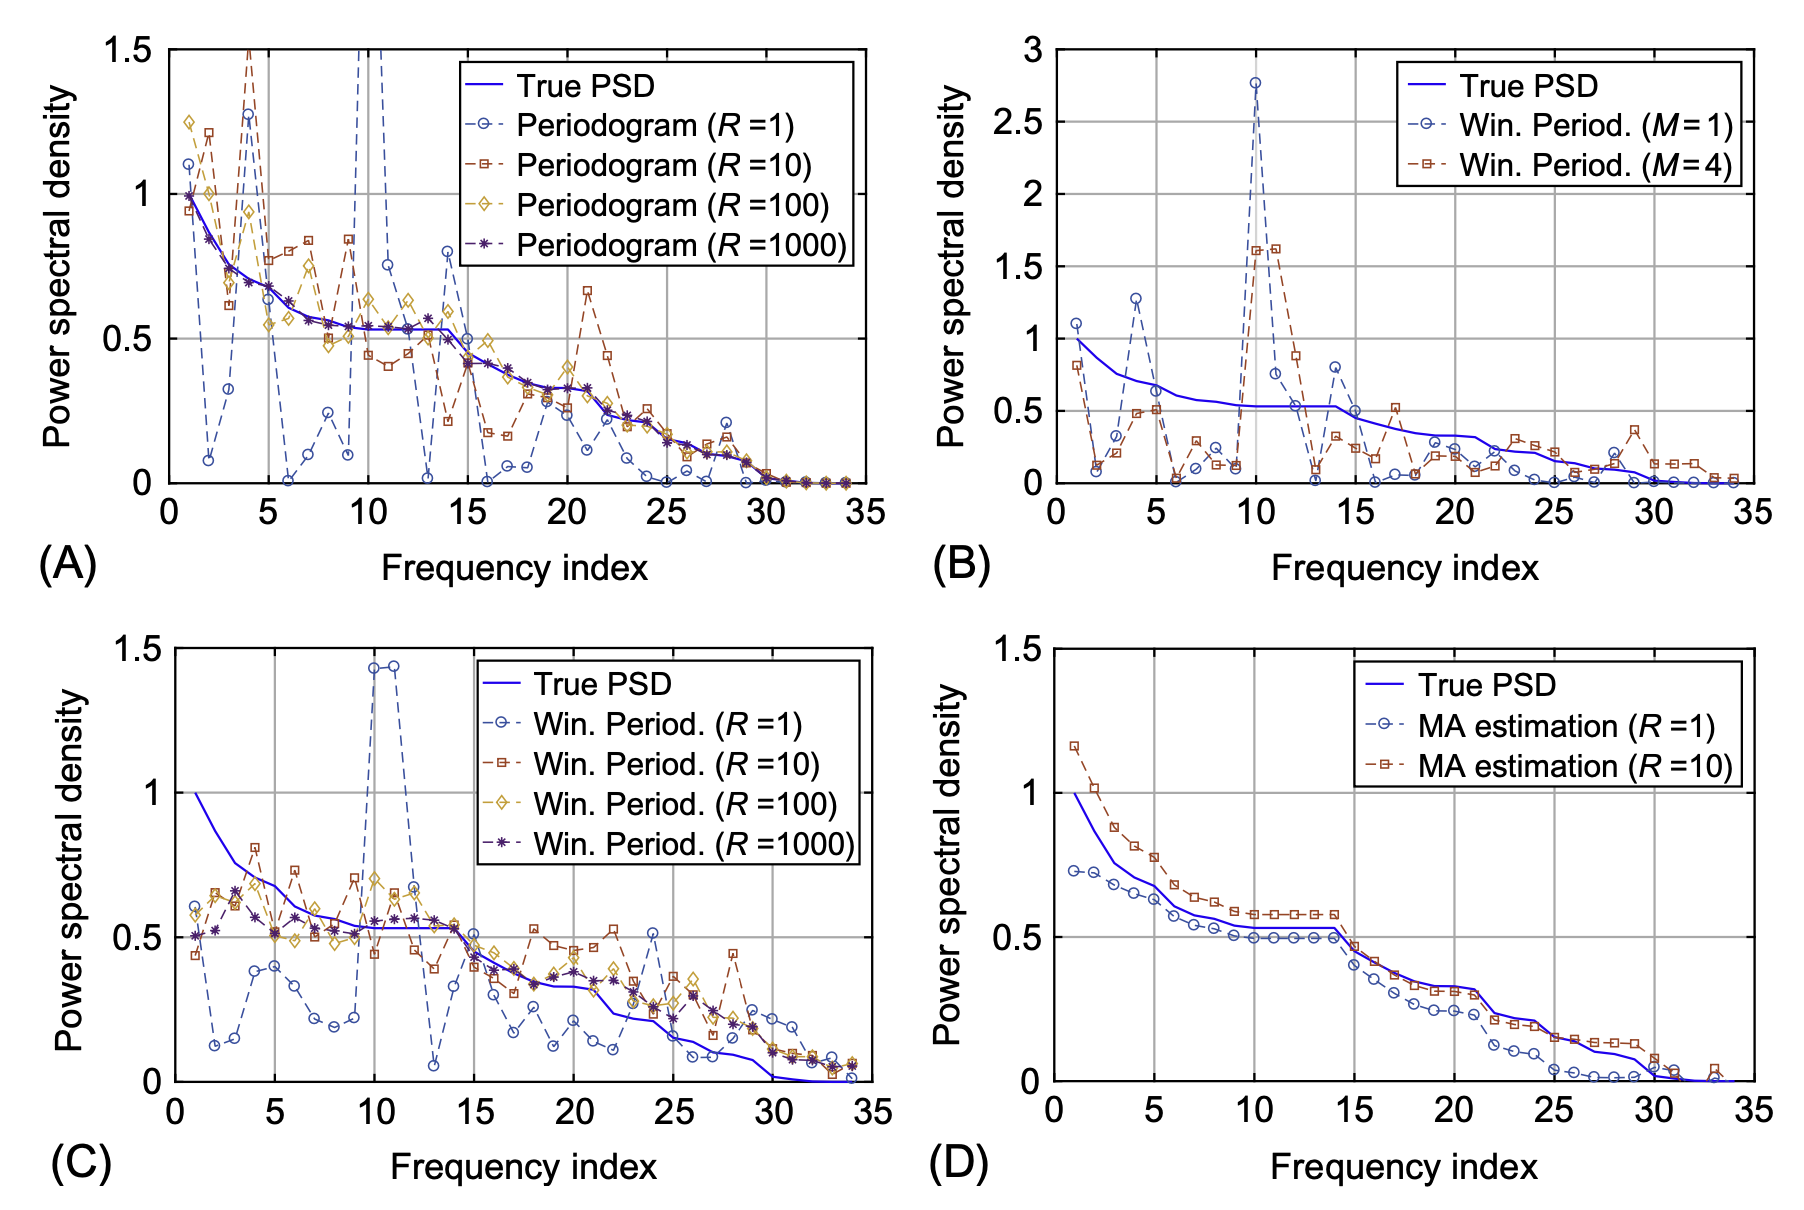
<figcaption aria-hidden="true">그림12.3(교재에서 긁어온 그림): Power
spectral density estimation. All estimators are based on the same random
process defined on the Karate club network <span class="citation"
data-cites="zachary1977information">(Zachary 1977)</span>. (A)
Periodogram estimation with different numbers of observations. (B)
Windowed average periodogram from a single realization and a different
number of windows. (C) Windowed average periodogram for four windows and
a varying number of realizations. (D) Parametric MA estimation for 1 and
10 realizations.</figcaption>
</figure>

이 그림은 다양한 방법으로 true PSD ${\bf p}$를 추정한 결과를 나타내는
PSD plot 이다[1]. 우리가 적용한 방법은 (A)에서 $R=1$일 경우이다. 보는것
처럼 true PSD 를 놀라울 정도로 제대로 추정하지 못한다[2]. 만약에 우리가
모형에서 하나의 시계열이 아니라 1000개의 정도의 시계열을 관측하였다면 좀
더 합리적으로 추정할 수 있다. 그런데 사실 하나의 모형에서 1000개씩이나
되는 시계열을 관측하는 일은 현실적으로 불가능하다[3] 따라서 우리는
비교적 적은 $R$에서 합리적인 PSD의 추정치를 이끌어내야 한다. 그림
(B),(C)는 상대적으로 적은 $R$에 대해 ${\bf p}$를 추정하는 windowed
periodogram 을 이용하여 PSD를 추정한 결과이다. (C)를 살펴보면 $R=1$
일경우 ${\bf p}$를 추정한 값들이 나와있는데 (A)와 비교하면 꽤 합리적으로
보인다.

문제는 (A)-(C)에서 제안된 방법 모두가 (D)에 제시된 전통적인 방법에
비하여 퍼포먼스가 떨어진다는 것이다. (D)는 parametric 모형을 사용한
결과이다. 파라메트릭 방법이므로 특정 모델을 한정하고 거기에 대응하는
한두개의 모수만 추정하면 되므로 추정이 잘 된다.[4] 반면 (A)-(C)의 경우
한 두개의 파라메터가 아니라 ${\bf p}$의 모든 원소를 추정해야하므로
추정할 파라메터가 데이터의 수 $N$과 같다[5]. 따라서 추정치의 분산이
크다. 사실 이것은 파라메트릭 방법과 세미파라메트릭 방법이라는 구조적인
차이때문에 어쩔 수 없는 것 같다. 그래도 세미파라메트릭 방법은 머리아프게
모델링을 할 필요가 없고[6] 내가 적합한 모델이 맞는지 확인할 필요도
없다[7]는 장점이 있다.

아래는 나름 PSD를 추정하는 신기술인 것 같다.

<figure>
<img
src="attachment:2022-12-27-Chap-12.2.1~12.3.1_files/figure-ipynb/da2b1b30-ea09-4d72-afa3-ed2f27566c6b-1-f9528ecc-9143-4e3b-bff7-18e4b23a9651.png"
alt="그림12.4(교재에서 긁어온 그림): PSD estimation from a subset of nodes. Estimators are based on a random process defined on the Karate club network (Zachary 1977). (A) Graph sampling for nonparametric PSD estimation. Here, 20 out of 34 nodes are observed. The sampled nodes are highlighted by the circles around the nodes. (B) Nonparametric PSD estimation based on observations from 20 nodes and 100 data snapshots. (C) Graph sampling for parametric MA PSD estimation. Here, 4 out of 34 nodes are observed. (D) Parametric MA PSD estimation based on observations from 4 nodes and 100 data snapshots." />
<figcaption aria-hidden="true">그림12.4(교재에서 긁어온 그림): PSD
estimation from a subset of nodes. Estimators are based on a random
process defined on the Karate club network <span class="citation"
data-cites="zachary1977information">(Zachary 1977)</span>. (A) Graph
sampling for nonparametric PSD estimation. Here, 20 out of 34 nodes are
observed. The sampled nodes are highlighted by the circles around the
nodes. (B) Nonparametric PSD estimation based on observations from 20
nodes and 100 data snapshots. (C) Graph sampling for parametric MA PSD
estimation. Here, 4 out of 34 nodes are observed. (D) Parametric MA PSD
estimation based on observations from 4 nodes and 100 data
snapshots.</figcaption>
</figure>

그래프신호의 sub-sampling을 이용하는 것 같은데 교재의 뒤쪽에
서술되어있다. $R=100$임을 고려하여도 퍼포먼스가 좋은 편인듯 하다[8].

Djuric, Petar, and Cédric Richard. 2018. *Cooperative and Graph Signal
Processing: Principles and Applications*. Academic Press.

Segarra, Santiago, Antonio G Marques, Gonzalo Mateos, and Alejandro
Ribeiro. 2017. “Network Topology Inference from Spectral Templates.”
*IEEE Transactions on Signal and Information Processing over Networks* 3
(3): 467–83.

Zachary, Wayne W. 1977. “An Information Flow Model for Conflict and
Fission in Small Groups.” *Journal of Anthropological Research* 33 (4):
452–73.

[1] x축이 freq, y축이 PSD

[2] 맞추는게 없는 것 같은데?

[3] 그리고 대부분 $R=1$이지..

[4] 약간 바이어스가 있어보이긴 하는데, 우연히 생긴건지 이론적으로 항상
생기는 건지는 잘 모르겠네?

[5] 이런걸 세미파라메트릭 모형이라고 해요

[6] 그래서 플랏을 보면서 적당한 ARMA를 찾을 필요도 없고, AIC 니 BIC 를
따져가면서 모형선택을 할 필요도 없고

[7] 적합이후에 잔차분석 같은거 안해도 된다는 의미

[8] 내 생각엔 이게 핵심 기술인 것 같음
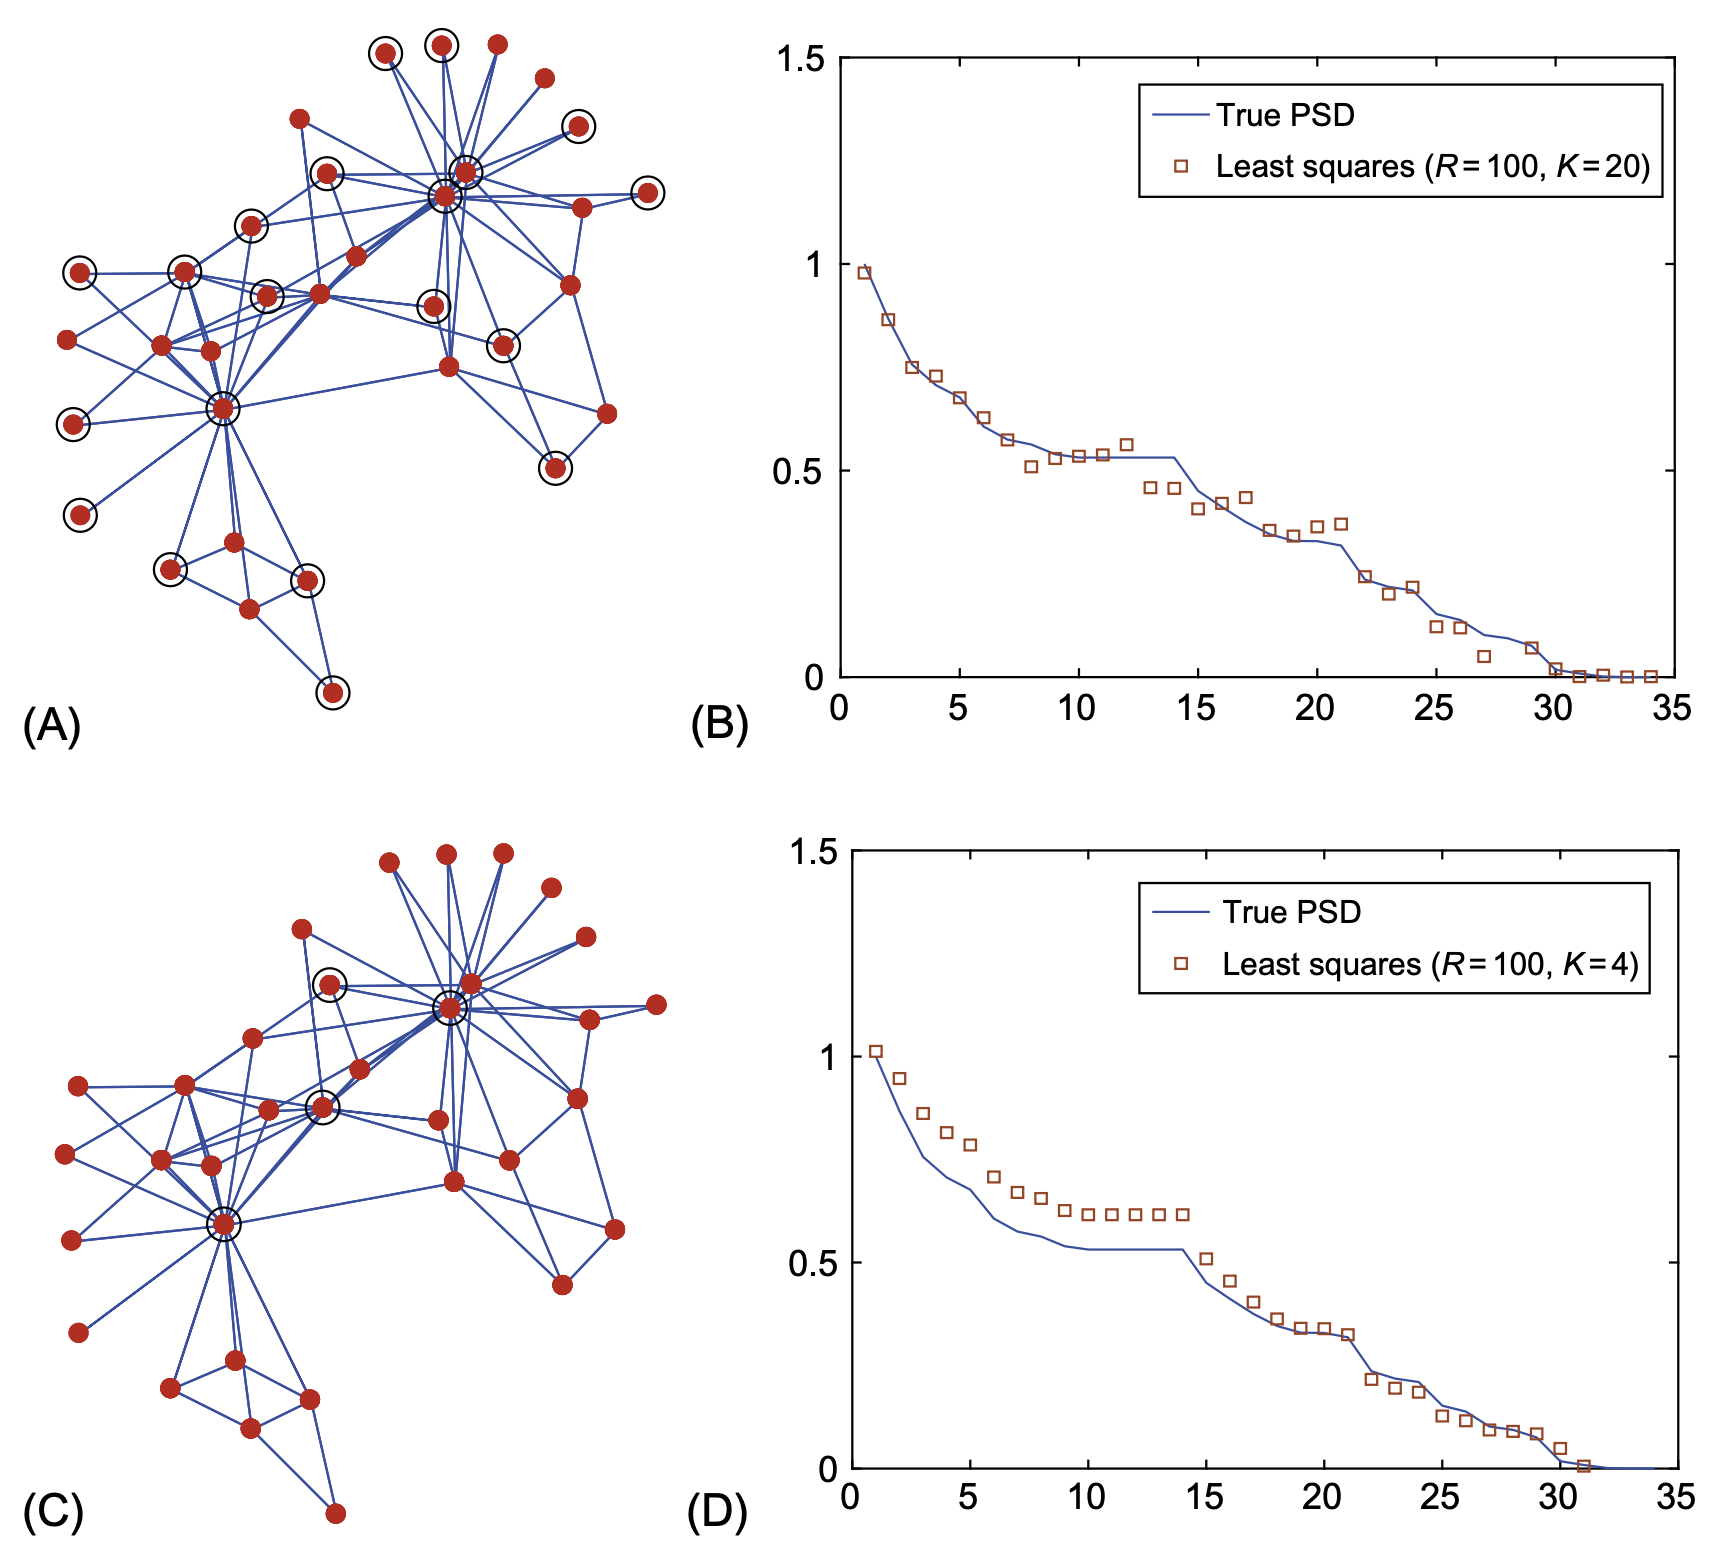